# Import Libraries

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'carsforsale:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2354614%2F3967386%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T052023Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4308a5c8848526ea00397e1089e13ac06804b370030178a2fea0098a25215ee2bb81803c03d2a1cd88b618726caee7fa814429ad840bdec91f2bcff72e33d7e0fafd76145695a7577e3b4e7d5b0486914cdef165c06a6d803b64aa7d8b5847d43130a3e35c368e714b269208f50cb1cd7cf00fe6a63c7ba87ca27f3178d8de78a29f5f11512d6e944c1d29a3691129eaa5be25bda73bf40fc705fbcf1f6c806d40ad01cebd5e0d2ac9d99fbe80fd12bbfaf71712ad990136511148d0aaf83ed6470b50110e92d2475992c8a592dc57e149a8c8d801291c259c52bcb0a2bdfc90a64cc6bf5875c5cb7b4cbfb8c740ac6ce2e91b94b158c8f7513fd4666eb2d42e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 810173 bytes downloaded
Downloaded and uncompressed: carsforsale
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline



pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carsforsale/cars_raw.csv


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression # LinearRegression algortimasını import ediyoruz.

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# modelimizin çıkan sonuçlarnı değerlendirmek için kullanılan görselleştirme kütüphaneleri

from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz
from yellowbrick.regressor import ResidualsPlot

from sklearn.tree import DecisionTreeRegressor


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

kullanılacak sütunlar:
- Year: Modelin yılı
- Make: araba'nın markası
- Model: arabanın modeli
- Used_New: ullanılıp kullanılmadığı
- Price(target): satıştaki fiyatı
- Consumer rating: arabaya gelen ortalama rate sayısı
- Consumer reviews: arbaaya gelen ortalama yorum sayısı
- seller type(categorik):dealer-private
- seller rating: satısıcının puanı
- seller review: satıcının aldığı yorumların ortalama
- deal type: satıcının pazarlığa olan davranışı
- ComfortRating	: arabanın rahatlığı
- InteriorDesignRating	: iç tasarımının değerlendirilmesi
- PerformanceRating: arabanın performansının değerlendirilmesi
- ValueForMoneyRating
- ExteriorStylingRating
- ReliabilityRating
- drive train: araç hareketinin nasıl sağlandığı ile ilgili
- fuel type
- MinMPG
- MaxMPG
- Engine
- transmission
- mileage

In [ ]:
df= pd.read_csv("/kaggle/input/carsforsale/cars_raw.csv")

In [ ]:
df.head()

,Year,Make,Model,Used/New,Price,ConsumerRating,ConsumerReviews,SellerType,SellerName,SellerRating,SellerReviews,StreetName,State,Zipcode,DealType,ComfortRating,InteriorDesignRating,PerformanceRating,ValueForMoneyRating,ExteriorStylingRating,ReliabilityRating,ExteriorColor,InteriorColor,Drivetrain,MinMPG,MaxMPG,FuelType,Transmission,Engine,VIN,Stock#,Mileage
0,2019,Toyota,Sienna SE,Used,"$39,998",4.6,45,Dealer,CarMax Murrieta - Now offering Curbside Pickup and Home Delivery,3.3,3,25560 Madison Ave Murrieta,CA,92562,Great,4.7,4.6,4.6,4.4,4.6,4.7,Red,Black,Front-wheel Drive,19,27,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,5TDXZ3DC2KS015402,22998646,29403
1,2018,Ford,F-150 Lariat,Used,"$49,985",4.8,817,Dealer,Giant Chevrolet,4.8,131,1001 S Ben Maddox Way Visalia,CA,93292,Good,4.9,4.8,4.8,4.6,4.8,4.7,Shadow Black,Black,Four-wheel Drive,19,24,Gasoline,10-Speed Automatic,3.5L V6 24V PDI DOHC Twin Turbo,1FTEW1EG2JFD44217,22418A,32929
2,2017,RAM,1500 Laramie,Used,"$41,860",4.7,495,Dealer,Gill Auto Group Madera,4.6,249,1100 S Madera Ave Madera,CA,93637,Good,4.8,4.7,4.8,4.6,4.8,4.7,Granite Crystal Clearcoat Metallic,Black,Four-wheel Drive,15,21,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,1C6RR7VT5HS842283,NG277871G,23173
3,2021,Honda,Accord Sport SE,Used,"$28,500",5.0,36,Dealer,AutoSavvy Las Vegas,4.6,284,2121 E Sahara Ave Las Vegas,NV,89104,NaN,4.9,5.0,4.9,5.0,5.0,5.0,Gray,–,Front-wheel Drive,29,35,Gasoline,Automatic CVT,1.5L I4 16V GDI DOHC Turbo,1HGCV1F49MA038035,54237,10598
4,2020,Lexus,RX 350,Used,"$49,000",4.8,76,Dealer,Lexus of Henderson,4.8,4755,7737 Eastgate Rd Henderson,NV,89011,Good,4.9,4.8,4.8,4.7,4.8,4.9,Eminent White Pearl,Birch,Front-wheel Drive,20,27,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,2T2AZMAA8LC156270,HDT4181A,28137


In [ ]:
df.describe().T

# If standard deviation is greater than or close to the mean, it gives us an inference that there is an outlier problem in our data.

# If there is a gap between the "min" and the first quartile of 25% and/or between the 3rd quartile of 75% and the "max", it provides an inference that there may be a limited number of outlier values in our data, but not in general.

,count,mean,std,min,25%,50%,75%,max
Year,9379.00,2018.72,2.22,2001.00,2018.00,2019.00,2020.00,2022.00
ConsumerRating,9379.00,4.70,0.24,2.50,4.70,4.80,4.80,5.00
ConsumerReviews,9379.00,133.19,154.99,1.00,30.00,75.00,182.00,817.00
SellerRating,9379.00,4.41,0.63,1.00,4.30,4.60,4.80,5.00
SellerReviews,9379.00,984.09,1609.04,1.00,112.00,542.00,1272.00,27824.00
ComfortRating,9379.00,4.77,0.22,3.00,4.70,4.80,4.90,5.00
InteriorDesignRating,9379.00,4.73,0.19,2.80,4.70,4.80,4.80,5.00
PerformanceRating,9379.00,4.70,0.25,1.00,4.60,4.70,4.80,5.00
ValueForMoneyRating,9379.00,4.54,0.34,1.00,4.50,4.60,4.70,5.00
ExteriorStylingRating,9379.00,4.78,0.17,3.00,4.70,4.80,4.90,5.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   9379 non-null   int64  
 1   Make                   9379 non-null   object 
 2   Model                  9379 non-null   object 
 3   Used/New               9379 non-null   object 
 4   Price                  9379 non-null   object 
 5   ConsumerRating         9379 non-null   float64
 6   ConsumerReviews        9379 non-null   int64  
 7   SellerType             9379 non-null   object 
 8   SellerName             9379 non-null   object 
 9   SellerRating           9379 non-null   float64
 10  SellerReviews          9379 non-null   int64  
 11  StreetName             9379 non-null   object 
 12  State                  9379 non-null   object 
 13  Zipcode                9379 non-null   object 
 14  DealType               9157 non-null   object 
 15  Comf

# EDA

In [ ]:
#We looked columns as a object
df.select_dtypes(include ="object").head()

,Make,Model,Used/New,Price,SellerType,SellerName,StreetName,State,Zipcode,DealType,ExteriorColor,InteriorColor,Drivetrain,FuelType,Transmission,Engine,VIN,Stock#
0,Toyota,Sienna SE,Used,"$39,998",Dealer,CarMax Murrieta - Now offering Curbside Pickup and Home Delivery,25560 Madison Ave Murrieta,CA,92562,Great,Red,Black,Front-wheel Drive,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,5TDXZ3DC2KS015402,22998646
1,Ford,F-150 Lariat,Used,"$49,985",Dealer,Giant Chevrolet,1001 S Ben Maddox Way Visalia,CA,93292,Good,Shadow Black,Black,Four-wheel Drive,Gasoline,10-Speed Automatic,3.5L V6 24V PDI DOHC Twin Turbo,1FTEW1EG2JFD44217,22418A
2,RAM,1500 Laramie,Used,"$41,860",Dealer,Gill Auto Group Madera,1100 S Madera Ave Madera,CA,93637,Good,Granite Crystal Clearcoat Metallic,Black,Four-wheel Drive,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,1C6RR7VT5HS842283,NG277871G
3,Honda,Accord Sport SE,Used,"$28,500",Dealer,AutoSavvy Las Vegas,2121 E Sahara Ave Las Vegas,NV,89104,NaN,Gray,–,Front-wheel Drive,Gasoline,Automatic CVT,1.5L I4 16V GDI DOHC Turbo,1HGCV1F49MA038035,54237
4,Lexus,RX 350,Used,"$49,000",Dealer,Lexus of Henderson,7737 Eastgate Rd Henderson,NV,89011,Good,Eminent White Pearl,Birch,Front-wheel Drive,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,2T2AZMAA8LC156270,HDT4181A


In [ ]:
# kategorik verilerde unique değerlere baktık
for col in df.select_dtypes('object'):
    print(f"{col:<20}:", df[col].nunique())# col<20: çıktının daha okunabilri hale gelmesi için

Make                : 41
Model               : 1304
Used/New            : 26
Price               : 5064
SellerType          : 2
SellerName          : 3971
StreetName          : 3967
State               : 59
Zipcode             : 2163
DealType            : 3
ExteriorColor       : 949
InteriorColor       : 374
Drivetrain          : 10
FuelType            : 13
Transmission        : 93
Engine              : 326
VIN                 : 8474
Stock#              : 8431


In [ ]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

,Year,Make,Model,Used/New,Price,ConsumerRating,ConsumerReviews,SellerType,SellerName,SellerRating,SellerReviews,StreetName,State,Zipcode,DealType,ComfortRating,InteriorDesignRating,PerformanceRating,ValueForMoneyRating,ExteriorStylingRating,ReliabilityRating,ExteriorColor,InteriorColor,Drivetrain,MinMPG,MaxMPG,FuelType,Transmission,Engine,VIN,Stock#,Mileage
212,2004,Toyota,Highlander Base,Used,"$5,995",4.50,47,Dealer,Northtown Auto Sales,4.90,2,8325 University Ave NE Minneapolis,MN,55432,Good,4.60,4.30,4.40,4.60,4.30,4.70,Tan,Tan,Front-wheel Drive,23,23,Gasoline,Automatic 5-Speed,3.3L V6,JTEGP21A740039991,40039991STK,204440
4930,2004,Toyota,Highlander Base,Used,"$5,995",4.50,47,Dealer,Northtown Auto Sales,4.90,2,8325 University Ave NE Minneapolis,MN,55432,Good,4.60,4.30,4.40,4.60,4.30,4.70,Tan,Tan,Front-wheel Drive,23,23,Gasoline,Automatic 5-Speed,3.3L V6,JTEGP21A740039991,40039991STK,204440
2607,2005,Acura,MDX Touring,Used,"$6,495",4.70,54,Dealer,JP Motors,4.30,7,7411 Centreville Rd Manassas,VA,20111,Good,4.80,4.50,4.60,4.80,4.60,4.90,Black,Ebony,Four-wheel Drive,17,23,Gasoline,5-Speed Automatic,3.5L V6 24V MPFI SOHC,2HNYD188X5H549256,2P771090,174916
7006,2005,Acura,MDX Touring,Used,"$6,495",4.70,54,Dealer,JP Motors,4.30,7,7411 Centreville Rd Manassas,VA,20111,Good,4.80,4.50,4.60,4.80,4.60,4.90,Black,Ebony,Four-wheel Drive,17,23,Gasoline,5-Speed Automatic,3.5L V6 24V MPFI SOHC,2HNYD188X5H549256,2P771090,174916
1716,2007,Toyota,Camry LE,Used,"$9,950",4.20,301,Dealer,TJK AUTO LLC,4.10,10,14227 S Street Omaha,NE,68137,Great,4.40,4.10,4.10,4.20,4.30,4.30,White,Tan,Front-wheel Drive,22,31,Gasoline,6-Speed Automatic,3.5L V6 24V MPFI DOHC,4T1BK46K87U548913,548913,99223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,2022,Tesla,Model 3 Long Range,Used,"$66,237",4.80,2,Dealer,Napleton's Volkswagen of Sanford,4.60,795,4175 S. Orlando Sanford,FL,32773,Good,5.00,4.50,5.00,4.50,4.50,5.00,Midnight Silver Metallic,Black,All-wheel Drive,0,0,Electric,Automatic,Electric,5YJ3E1EB0NF119495,ZNF119495P,2224
1596,2022,Toyota,Highlander Hybrid Limited,Used,"$52,955",5.00,2,Dealer,AutoNation Toyota Hayward,4.40,1071,24773 Mission Blvd Hayward,CA,94544,Great,5.00,5.00,5.00,5.00,5.00,5.00,Ruby Flare Pearl,–,All-wheel Drive,35,34,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,5TDXBRCH7NS543753,NS543753,29994
4898,2022,Toyota,Highlander Hybrid Limited,Used,"$52,955",5.00,2,Dealer,AutoNation Toyota Hayward,4.40,1071,24773 Mission Blvd Hayward,CA,94544,Great,5.00,5.00,5.00,5.00,5.00,5.00,Ruby Flare Pearl,–,All-wheel Drive,35,34,Hybrid,Automatic CVT,2.5L I4 16V PDI DOHC Hybrid,5TDXBRCH7NS543753,NS543753,29994
3145,2022,Volvo,XC60 B5 Inscription,Used,"$48,500",2.70,1,Dealer,Volvo Cars Mall of Georgia,4.90,2106,3626 Buford Dr NE Buford,GA,30519,Good,5.00,5.00,1.00,1.00,5.00,1.00,Crystal White Metallic,Blonde,Front-wheel Drive,23,30,Gasoline,8-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,YV4L12DL6N1951540,LC422005B,18310


In [ ]:
def clean_data(df):
    #used-new column replaced to categorical column as a 2 category
    df["Used/New"] = df["Used/New"].str.replace(r'.*Certified.*', 'Certified', regex=True)

    #Price column cleaned and turned to float
    df["Price"] = df["Price"].astype(str).str.replace('$', '').str.replace(',', '.')
    df["Price"] = pd.to_numeric(df["Price"], errors='coerce')

    #drive-train column
    nan_drivetrain = df["Drivetrain"].isna()
    df["Drivetrain"] = df["Drivetrain"].replace("–", np.nan)

    df["Drivetrain"]=df["Drivetrain"].str.replace("All-wheel Drive", "AWD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Front-wheel Drive", "FWD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Front Wheel Drive", "FWD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Four-wheel Drive", "4WD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Rear-wheel Drive", "RWD")

    df["Drivetrain"].loc[nan_drivetrain] = np.nan

    #Transmission
    df.Transmission = df.Transmission.str.lower()
    df.Transmission = df.Transmission.str.replace("-", " ")
    df.Transmission = df.Transmission.str.replace("m/t", "manual")
    df.Transmission = df.Transmission.str.replace("a/t", "automatic")
    df.Transmission = df.Transmission.replace("–", np.nan)

    df.Engine = df.Engine.replace("–", np.nan)


    #FuelType
    df["FuelType"]= df["FuelType"].replace("–",np.nan)

    return df


In [ ]:
def fill_na(df):
    # Drivetrain sütunundaki NaN değerlerini doldurma
    #Model ve markaya göre drivetrain grupladık sonra burdan aldığımız değerlerle null değerleri doldurduk. mode değeri
    drive_train_df = df.groupby(["Make", "Model"])["Drivetrain"].apply(lambda x: x.mode()[0] if x.mode().any() else None).reset_index()
    df = pd.merge(df, drive_train_df, on=["Make", "Model"], suffixes=('', '_ref'), how='left')
    df['Drivetrain'] = df['Drivetrain'].fillna(df['Drivetrain_ref'])
    df.drop("Drivetrain_ref", axis=1,inplace=True)
    value_counts_dr = df.Drivetrain.isna().sum()


    # DealType sütunundaki NaN değerlerini doldurma
    deal_type_df = df.groupby("SellerName")["DealType"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    df = pd.merge(df, deal_type_df, on="SellerName", suffixes=('', '_ref'), how='left')
    df['DealType'] = df['DealType'].fillna(df['DealType_ref'])
    df.drop("DealType_ref", axis=1,inplace=True)
    value_counts_dt = df.DealType.isna().sum()


    # FuelType sütunundaki NaN değerlerini doldurma
    fuel_type_df = df.groupby(["Make", "Model"])["FuelType"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    df = pd.merge(df, fuel_type_df, on=["Make", "Model"], suffixes=('', '_ref'), how='left')
    df['FuelType'] = df['FuelType'].fillna(df['FuelType_ref'])
    df.drop(columns=['FuelType_ref'], inplace=True)
    value_counts_ft = df.FuelType.isna().sum()

    df.dropna(subset=["Price"], inplace=True)

    df.dropna(subset=["Transmission"], inplace=True)
    df.dropna(subset=["Engine"], inplace=True)


    if value_counts_dr > 0:
        print("There are", value_counts_dr, "Drivetrain values left as NaN.")
        df.dropna(subset=["Drivetrain"], inplace=True)
    else:
        print(value_counts_dr, "value droped")

    if value_counts_dt > 0:
        print("There are", value_counts_dt, "DealType values left as NaN.")
        df.dropna(subset=["DealType"], inplace=True)
    else:
        print(value_counts_dt, + "value droped")

    if value_counts_ft > 0:
        print("There are", value_counts_ft, "FuelType values left as NaN.")
        df.dropna(subset=["FuelType"], inplace=True)
    else:
        print(value_counts_ft,"value droped")

    return df


In [ ]:
# Checks for duplicate observations in the data set and removes them

def duplicate_values(df):

    print("Duplicate check:")
    num_duplicates = df.duplicated(subset=None, keep='first').sum() #ilk görülen çift tutulur diğeri çift olarak işaretlenir

    if num_duplicates > 0:

        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print("No more duplicate rows!")

    else:
        print("There are no duplicated observations in the dataset.")

    return df

In [ ]:
#Fonksiyonları uygulama
df = duplicate_values(df)
df = clean_data(df)
df = fill_na(df)

Duplicate check:
There are 872 duplicated observations in the dataset.
872 duplicates were dropped!
No more duplicate rows!
There are 1 Drivetrain values left as NaN.
There are 104 DealType values left as NaN.
There are 4 FuelType values left as NaN.


## Splitin transmiision column

In [ ]:
import re

In [ ]:
auto_pattern = re.compile(r'\b(\d\s)?auto(matic)?\b|\bauto(matic)?\s(\d\b|\d\s\w+)?', re.IGNORECASE)
manual_pattern = re.compile(r'\b(\d\s)?manual\b|\bmanual\s\d\b', re.IGNORECASE)
speed_pattern = re.compile(r'(\d+)\s*speed', re.IGNORECASE)
cvt_pattern = re.compile(r'\b(cvt|continuously variable|xtronic continuously variable)\b', re.IGNORECASE)


def categorize_transmission(transmission):
    if cvt_pattern.search(transmission):
        return 'cvt'
    elif auto_pattern.search(transmission):
        return 'auto'
    elif manual_pattern.search(transmission):
        return 'manuel'
    else:
        return transmission

def extract_speed(transmission):
    match = speed_pattern.search(transmission)
    if match:
        return match.group(1)
    else:
        # "spd" yazısını kontrol eden ek desen
        spd_pattern = re.compile(r'(\d+)\s*spd', re.IGNORECASE)
        match = spd_pattern.search(transmission)
        return match.group(1) if match else None

df['Transmission_Type'] = df['Transmission'].apply(categorize_transmission)
df['Speed_Type'] = df['Transmission'].apply(extract_speed)

In [ ]:
df['Speed_Type'] = pd.to_numeric(df['Speed_Type'], errors='coerce')

In [ ]:
a = df[df.Speed_Type.isna()==True]  # bunlar üstünde ne işlem yapmam gerketiğini bilmiyorum. 1500 e yakın none değer var ve doldurulması imkansız ortalam ile doldurabilirim ama o zaman bozar çünkü cvt denen şey sınırsız vites demekmiş
a.Transmission_Type.value_counts()

Transmission_Type
cvt                               1169
auto                               360
variable                            26
transmission w/dual shift mode       4
manuel                               2
a                                    1
Name: count, dtype: int64

In [ ]:
max_speed_auto = df[df['Transmission_Type'] == 'auto']['Speed_Type'].dropna().max()
df.loc[(df['Transmission_Type'] == 'auto') & (df['Speed_Type'].isna()), 'Speed_Type'] = max_speed_auto


In [ ]:
#max_speed_cvt = df[df['Transmission_Type'] == 'cvt']['Speed_Type'].dropna().max()
df.loc[(df['Transmission_Type'] == 'cvt') & (df['Speed_Type'].isna()), 'Speed_Type'] = "cvt"


In [ ]:
todrop = df[df.Transmission_Type=="variable"].index
df.drop(index=todrop, inplace=True)

In [ ]:
df.dropna(subset=["Speed_Type"], inplace=True)

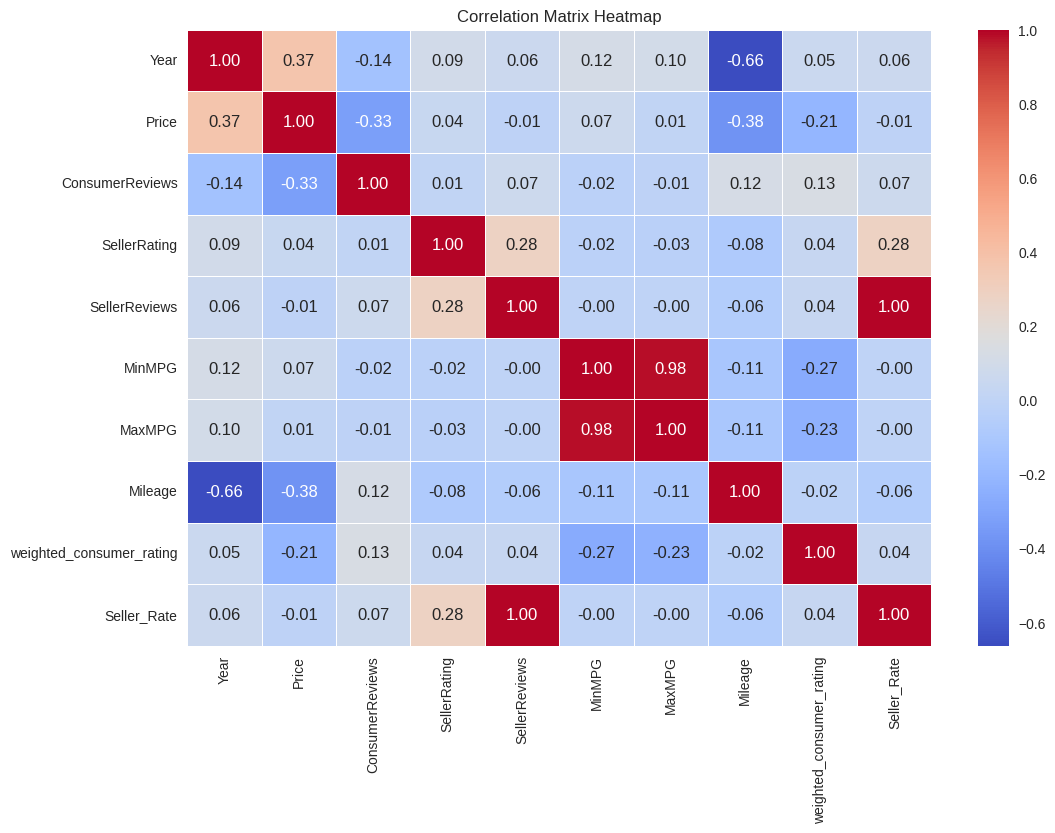

In [ ]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


## multicolinerty olan sütunlar üstünde işlme

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF hesaplama
X = df[['ComfortRating', 'InteriorDesignRating', 'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                 feature          VIF
0          ComfortRating  1807.688837
1   InteriorDesignRating  2281.832922
2      PerformanceRating   787.611758
3    ValueForMoneyRating  1095.260675
4  ExteriorStylingRating  1639.386624
5      ReliabilityRating  1003.948249


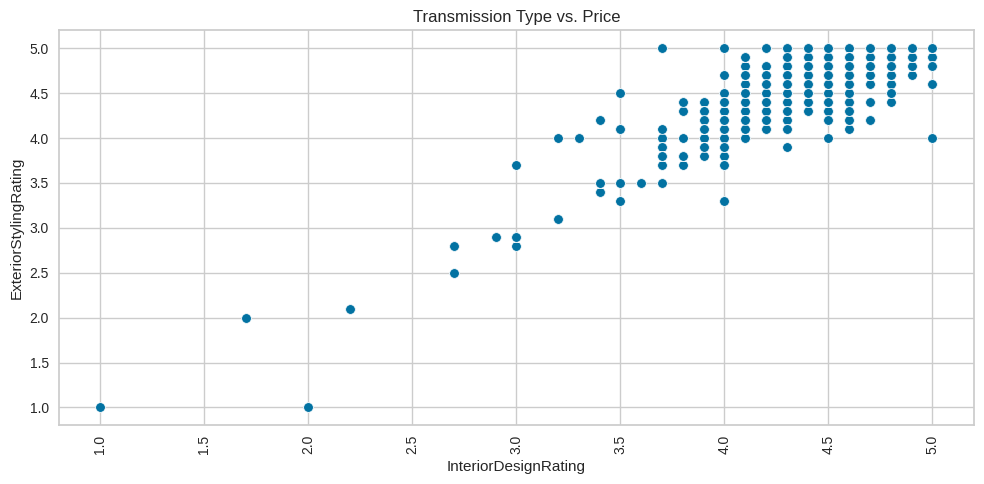

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='ValueForMoneyRating', y='ReliabilityRating', data=df, palette='viridis')
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price')
plt.xlabel('InteriorDesignRating')
plt.ylabel('ExteriorStylingRating')
plt.tight_layout()
plt.show()

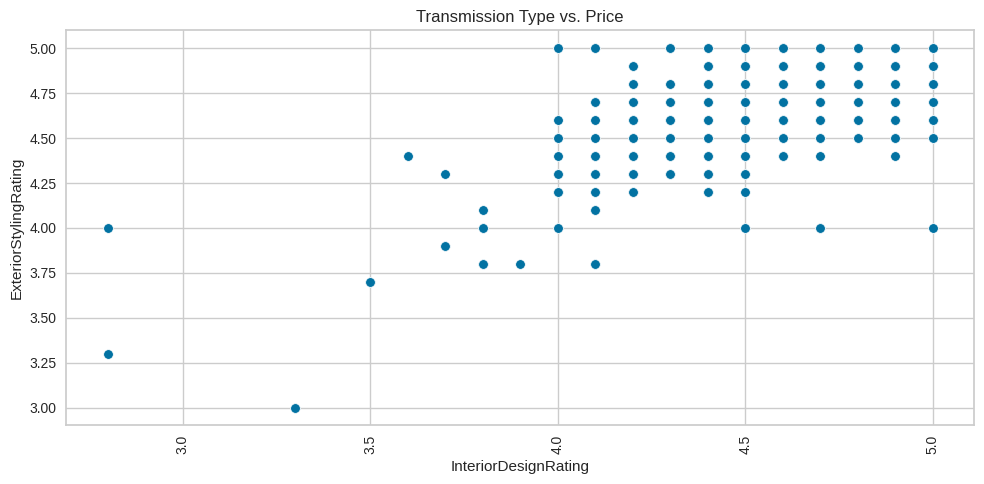

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='InteriorDesignRating', y='ExteriorStylingRating', data=df, palette='viridis')
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price')
plt.xlabel('InteriorDesignRating')
plt.ylabel('ExteriorStylingRating')
plt.tight_layout()
plt.show()

In [ ]:
#df['Rating'] = (df["ConsumerRating"]+df['ComfortRating'] + df['InteriorDesignRating'] + df['PerformanceRating'] + df['ValueForMoneyRating'] + df['ExteriorStylingRating'] + df['ReliabilityRating']) / 6


In [ ]:
cars_owner_rate = (df.ValueForMoneyRating * df.ReliabilityRating)
df["cars_owner_rate"] = cars_owner_rate

In [ ]:
df['weighted_consumer_rating'] = 0.7 * df['cars_owner_rate'] + 0.3 * df['ConsumerRating']


In [ ]:
df.drop(['cars_owner_rate'], axis=1, inplace=True)

In [ ]:
df.drop(['cars_owner_rate','ConsumerRating','ComfortRating', 'InteriorDesignRating', 'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating'], axis=1, inplace=True)

In [ ]:
to_drop = df[(df["MinMPG"] == 0) & (df["MaxMPG"] == 0)].index

df.drop(index=to_drop, inplace=True)

In [ ]:
max = df[df["MaxMPG"] == 0].index
df.drop(index=max, inplace=True)

In [ ]:
min= df[df["MinMPG"] == 0].index
df.drop(index=min, inplace=True)

In [ ]:
MPG = df.MinMPG * df.MaxMPG
df["MPG"] = MPG
df.drop(["MinMPG", "MaxMPG"], axis=1, inplace=True)

In [ ]:
#desing_rate = (df.InteriorDesignRating * df.ExteriorStylingRating)
#df["desing_rate"] = desing_rate

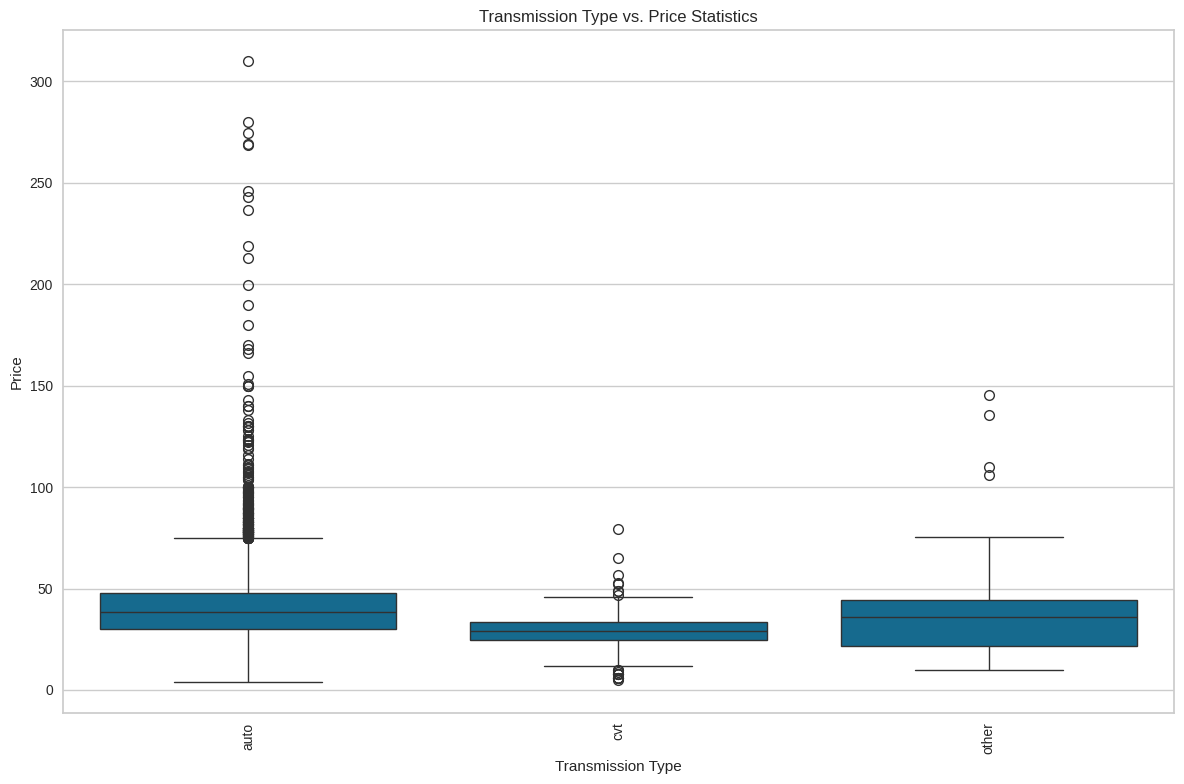

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Transmission_Type', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price Statistics')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [ ]:
df["Transmission_Type"].value_counts()

Transmission_Type
auto                                    7111
cvt                                     1171
manuel                                    31
7 speed                                    2
7 speed porsche doppelkupplung (pdk)       1
7 speed double clutch                      1
Name: count, dtype: int64

In [ ]:
df['Transmission_Type'] = df['Transmission_Type'].apply(lambda x: x if x in ['auto', 'cvt'] else 'other')


## Engine üstüne işlemler

In [ ]:
df["Engine"]=df["Engine"].str.replace("-", "")

In [ ]:
pattern_L = r"(\d+(\.\d+)?)\s*L\b"
pattern_VI = r"\b(V\d+|I\d+|H\d+)\b"
pattern_cylinder = r"(\d+)\s*cylinder\b|\b(\d+)\s*cyl\b|\b(\d+)\s*cyl\w*\b"

# Fonksiyonlar
def extract_litre(engine):
    match = re.search(pattern_L, engine)
    return match.group(1) if match else None

def extract_cylinder_arrangement(engine):
    match_VI = re.findall(pattern_VI, engine, flags=re.IGNORECASE)
    match_cylinder = re.findall(pattern_cylinder, engine, flags=re.IGNORECASE)

    if match_VI:
        return match_VI[-1]  # En son bulunan V veya I desenini döndür
    elif match_cylinder:
        for match in match_cylinder[0]:
            if match:
                return f"{match} Cylinder"  # Yakalanan silindir düzenini döndür
    else:
        return None

# Uygulama
df['Litre'] = df['Engine'].apply(extract_litre)
df.Litre = df.Litre.astype(float)
df['Cylindder_Arrangement'] = df['Engine'].apply(extract_cylinder_arrangement)

In [ ]:
df[df.Cylindder_Arrangement.isna()==True]  # mesela burda elektrikli araçların litre türünden motor hacmi olmazmış ynai yokmuş aslında bunlar drop edilebilir
#ama ben 0 ile dolduracağım
df.Litre = df.Litre.fillna(0)

In [ ]:
df[df.Cylindder_Arrangement.isna()==True]["Engine"].value_counts()

Engine
Electric                                           141
2.0L                                                27
2.5L                                                 7
Electric Motor                                       2
0.0                                                  2
0 0.0                                                1
6.0L W12 48V MPFI DOHC Twin Turbo                    1
Turbocharged Gas 1.5L/92                             1
NOT SPECIFIED NOT SPECIFIED                          1
6.0L W12 48V MPFI DOHC Twin Turbo Flexible Fuel      1
3.0L                                                 1
0 MOTOR AC PERMANENT MAGNET                          1
Name: count, dtype: int64

In [ ]:
df.Cylindder_Arrangement = df.Cylindder_Arrangement.str.replace("4 Cylinder", "I4").replace("6 Cylinder", "V6").replace("8 Cylinder", "V8").replace("10 Cylinder", "V10")

In [ ]:
df[df.Cylindder_Arrangement.isna() == True]

,Year,Make,Model,Used/New,Price,ConsumerReviews,SellerType,SellerName,SellerRating,SellerReviews,StreetName,State,Zipcode,DealType,ExteriorColor,InteriorColor,Drivetrain,FuelType,Transmission,Engine,VIN,Stock#,Mileage,Transmission_Type,Speed_Type,weighted_consumer_rating,MPG,Litre,Cylindder_Arrangement
163,2020,Tesla,Model Y Long Range,Used,65.995,10,Dealer,Victory Mitsubishi,3.4,472,4070 Boston rd Bronx,NY,10475,Great,Blue,–,AWD,Electric,1 speed automatic,Electric,5YJYGDEE8LF049382,17666,9561,auto,1.0,10.350,14478,0.0,None
171,2021,Tesla,Model Y Long Range,Used,71.277,15,Dealer,AutoFair Honda,4.8,3306,200 Keller Street Manchester,NH,03103,Good,Pearl White Multi,White / Black,AWD,Electric,1 speed automatic,Electric,5YJYGDEE4MF086057,HM11774C,15002,auto,1.0,11.042,15327,0.0,None
177,2020,Tesla,Model Y Long Range,Used,73.992,10,Dealer,Gilroy Chevrolet,4.6,143,6720 Automall Ct Gilroy,CA,95020,Good,White,White / Black,AWD,Electric,1 speed automatic,Electric,5YJYGDEEXLF020479,LF020479T,12332,auto,1.0,10.350,14478,0.0,None
285,2021,Tesla,Model Y Performance,Used,74.799,15,Dealer,INFINITI of San Antonio,4.7,507,12150 I-10 San Antonio,TX,78230,Good,Pearl White Multi,White / Black,AWD,Electric,1 speed automatic,Electric,5YJYGDEFXMF076271,MF076271,12708,auto,1.0,11.042,12190,0.0,None
299,2021,Tesla,Model Y Long Range,Used,74.900,15,Dealer,Heartland Chrysler Dodge Jeep Ram,4.5,111,2017 W Jesse James Rd Excelsior Springs,MO,64024,Good,White,Black,AWD,Electric,1 speed automatic,Electric,5YJYGDEE7MF248005,KP2827,10926,auto,1.0,11.042,15327,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8252,2019,Hyundai,Kona EV Limited,Used,31.975,13,Dealer,Bill Luke Tempe,4.8,1105,7833 S Autoplex Loop Tempe,AZ,85284,Good,Galactic Gray,Black,FWD,Electric,1 speed automatic,Electric,KM8K33AG8KU051279,BF25217,48116,auto,1.0,17.568,14256,0.0,None
8279,2022,Hyundai,IONIQ 5 SE,Used,54.999,6,Dealer,Hyundai of Palatine,4.5,481,221 E Lake Cook Rd Palatine,IL,60074,Good,Phantom Black,Gray,AWD,Electric,automatic,Electric,KM8KMDAF7NU084241,D818,121,auto,10.0,19.000,9570,0.0,None
8351,2020,Tesla,Model Y Long Range,Used,64.990,10,Dealer,Dallas Autos Direct,4.4,333,3228 Skylane Dr Carrollton,TX,75006,Good,Black,Black,AWD,Electric,1 speed automatic,Electric,5YJYGDEE1LF018636,LF018636,33077,auto,1.0,10.350,14478,0.0,None
8388,2018,Tesla,Model X 100D,Used,82.350,15,Dealer,Sheehy Ford Lincoln of Gaithersburg,4.9,3110,901 N. Frederick Ave. Gaithersburg,MD,20879,Fair,Deep Blue Metallic,Black,AWD,Electric,1 speed automatic,Electric,5YJXCBE2XJF102386,CMA2543A,41321,auto,1.0,13.691,7654,0.0,None


In [ ]:
df.Cylindder_Arrangement.value_counts(dropna = False)  #artık 9 tane unique değerimiz var ve de 186 tane none değerimiz

Cylindder_Arrangement
I4      3639
V6      2772
V8       993
I6       406
H4       242
None     186
H6        32
I3        22
V10       18
I5         7
Name: count, dtype: int64

In [ ]:
engine_na = (df['Engine'].str.contains("Electric")) & (df['Cylindder_Arrangement'].isna())

# Bu satırların 'Cylinder_Arrangement' sütununu "Electric" ile dolduruyoruz
df.loc[engine_na, 'Cylindder_Arrangement'] = "Electric"

In [ ]:
df.dropna(subset=["Cylindder_Arrangement"], inplace=True)

In [ ]:
df.isna().sum()

Year                        0
Make                        0
Model                       0
Used/New                    0
Price                       0
ConsumerReviews             0
SellerType                  0
SellerName                  0
SellerRating                0
SellerReviews               0
StreetName                  0
State                       0
Zipcode                     0
DealType                    0
ExteriorColor               0
InteriorColor               0
Drivetrain                  0
FuelType                    0
Transmission                0
Engine                      0
VIN                         0
Stock#                      0
Mileage                     0
Transmission_Type           0
Speed_Type                  0
weighted_consumer_rating    0
MPG                         0
Litre                       0
Cylindder_Arrangement       0
dtype: int64

In [ ]:
df.drop(["Engine","Transmission"], axis=1, inplace=True)

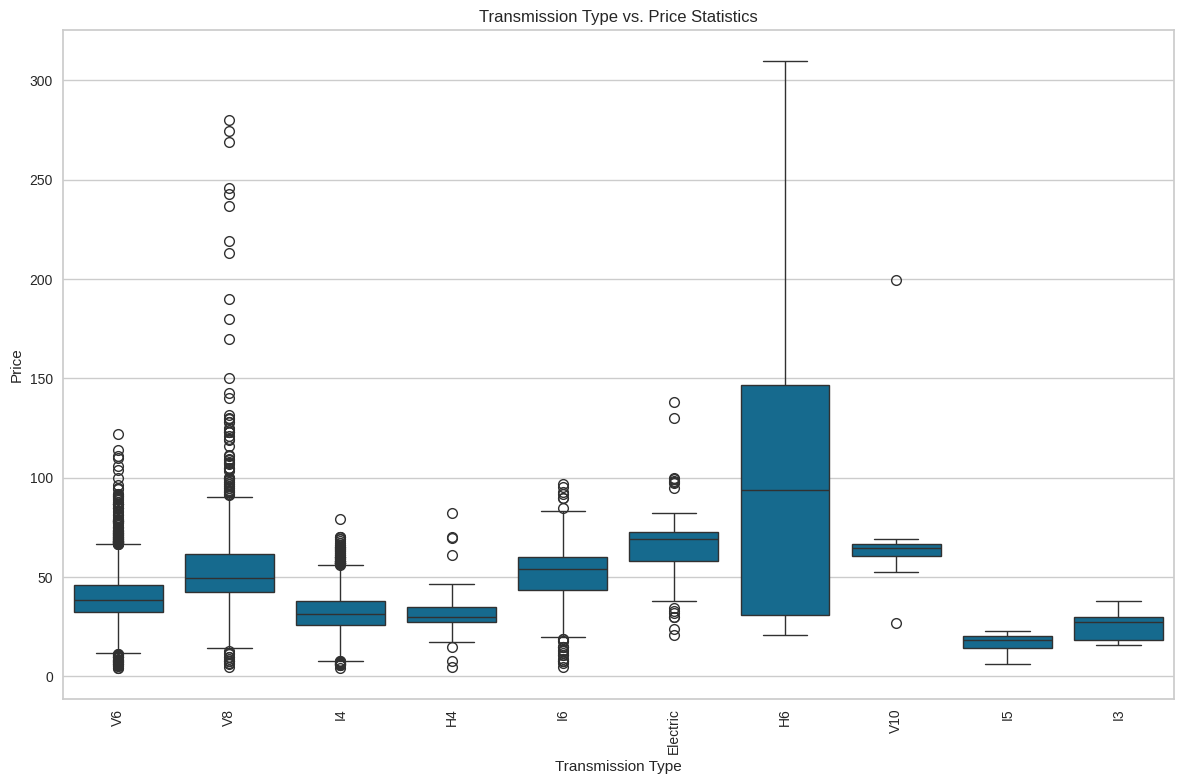

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cylindder_Arrangement', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price Statistics')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

 # Create Columns

In [ ]:
df["Make-Model"] = df["Make"] + " " + df["Model"]

In [ ]:
make_counts = df["Make"].value_counts()

In [ ]:
rare_make = make_counts[make_counts < 100].index

# Bu değerleri "Other" olarak yeniden kategorize edin
df['Make'] = df['Make'].apply(lambda x: 'Other' if x in rare_make else x)


In [ ]:
rare_make

Index(['Chrysler', 'Alfa', 'Jaguar', 'Mitsubishi', 'Genesis', 'Maserati',
       'Lamborghini', 'MINI', 'Scion', 'Mercury', 'FIAT', 'Bentley', 'Saturn'],
      dtype='object', name='Make')

In [ ]:
df["Make"].value_counts()

Make
BMW              834
Mercedes-Benz    736
Toyota           711
Honda            616
Ford             517
Jeep             457
Lexus            442
Chevrolet        380
Audi             348
Subaru           254
Cadillac         250
Nissan           232
Kia              214
GMC              213
Acura            206
Hyundai          200
INFINITI         190
Mazda            172
Other            164
Land             153
Tesla            142
RAM              135
Dodge            129
Volkswagen       127
Volvo            127
Porsche          112
Lincoln          110
Buick            103
Name: count, dtype: int64

In [ ]:
model_count = df.groupby("Make")["Model"].count().reset_index()
model_count.columns = ["Make", "Count_of_model"]

# df veri çerçevenize "Count_of_model" sütununu ekleyin
df = pd.merge(df, model_count, on="Make", how="left")

In [ ]:
#make-mode sütunu oluşturduk ve burda value count belli sayı üstünde olanları verimize ekledik
#value_counts = df['Make-Model'].value_counts()

# Eğer değer sayısı 100'den fazla ise, yeni bir sütun oluşturun
#for category, count in value_counts.items():
 #   if count >= 30:  # 100 yerine 2  yazdıysen One-hot-Encoding yapmış oluyoruz.
  #      df[category] = df['Make-Model'].apply(lambda x: int(category == x))

# Make-Model sütununu drop edin


In [ ]:
df.drop(columns=['Make-Model'], inplace=True)


In [ ]:
year_of_age = 2024 - df.Year
df["year_of_age"] = year_of_age

In [ ]:
plt.figure(figsize=(12, 6))
sns.pairplot(df, palette="Dark2")

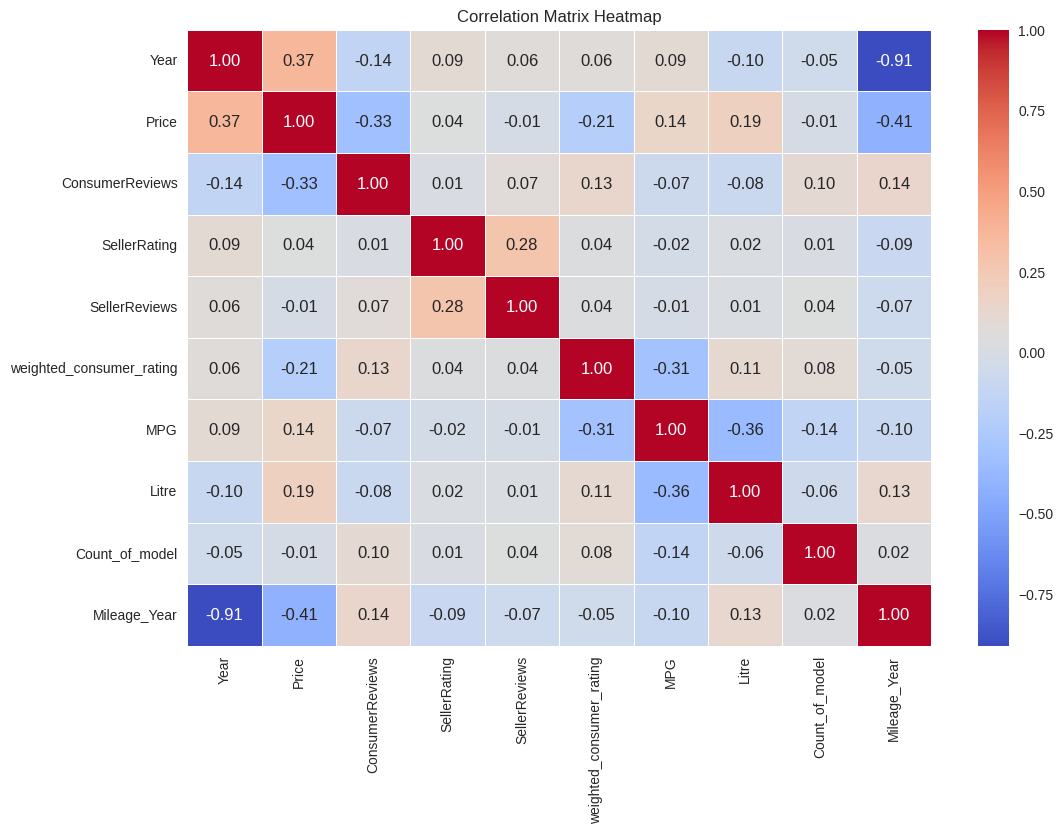

In [ ]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Veriyi ölçeklendirme
features = ['Mileage', 'year_of_age']
x = df[features].values
x = StandardScaler().fit_transform(x)

# PCA uygulama
pca = PCA(n_components=1)
principal_component = pca.fit_transform(x)

# Yeni bileşeni DataFrame'e ekleme
df['Mileage_Year'] = principal_component


In [ ]:
df.drop(['Mileage', 'year_of_age'], axis=1, inplace=True)

MinMPG: Şehir içi yakıt verimliliğini belirtir. Daha düşük değerler gösterir.
MaxMPG: Şehir dışı yakıt verimliliğini belirtir. Daha yüksek değerler gösterir.

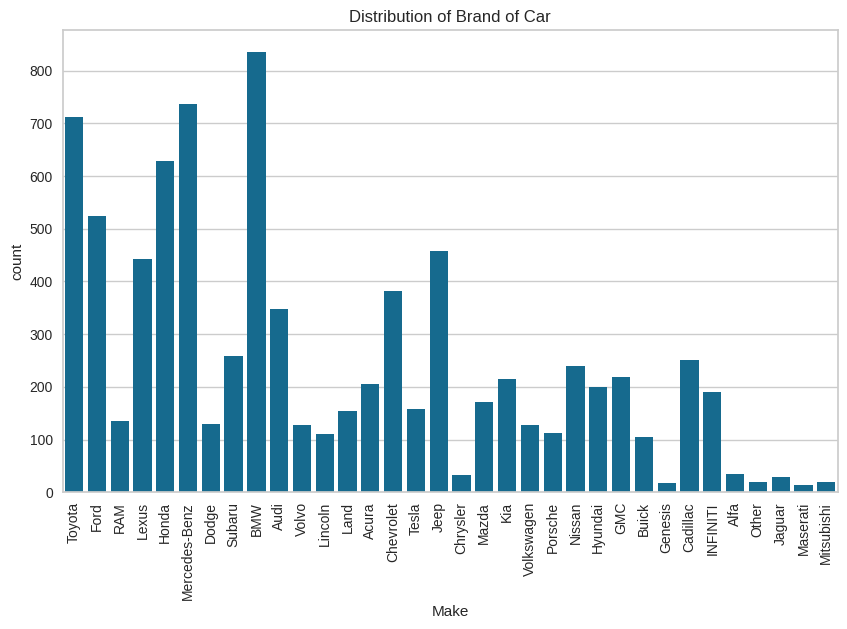

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Make')
plt.title(f'Distribution of Brand of Car')
plt.xticks(rotation=90)
plt.show()


In [ ]:
#value_counts = df['Make'].value_counts()

# Değer sayısı 2'den küçük olan indeksleri alalım
#to_drop = value_counts[value_counts < 2].index

# to_drop listesindeki indekslere sahip satırları düşürür
#df = df[~df['Make'].isin(to_drop)]

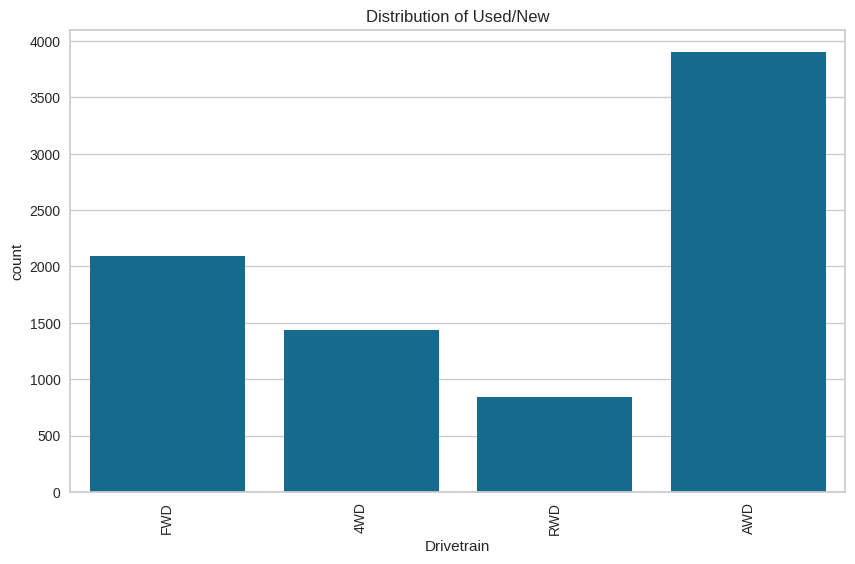

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Drivetrain')
plt.title(f'Distribution of Used/New')
plt.xticks(rotation=90)
plt.show()


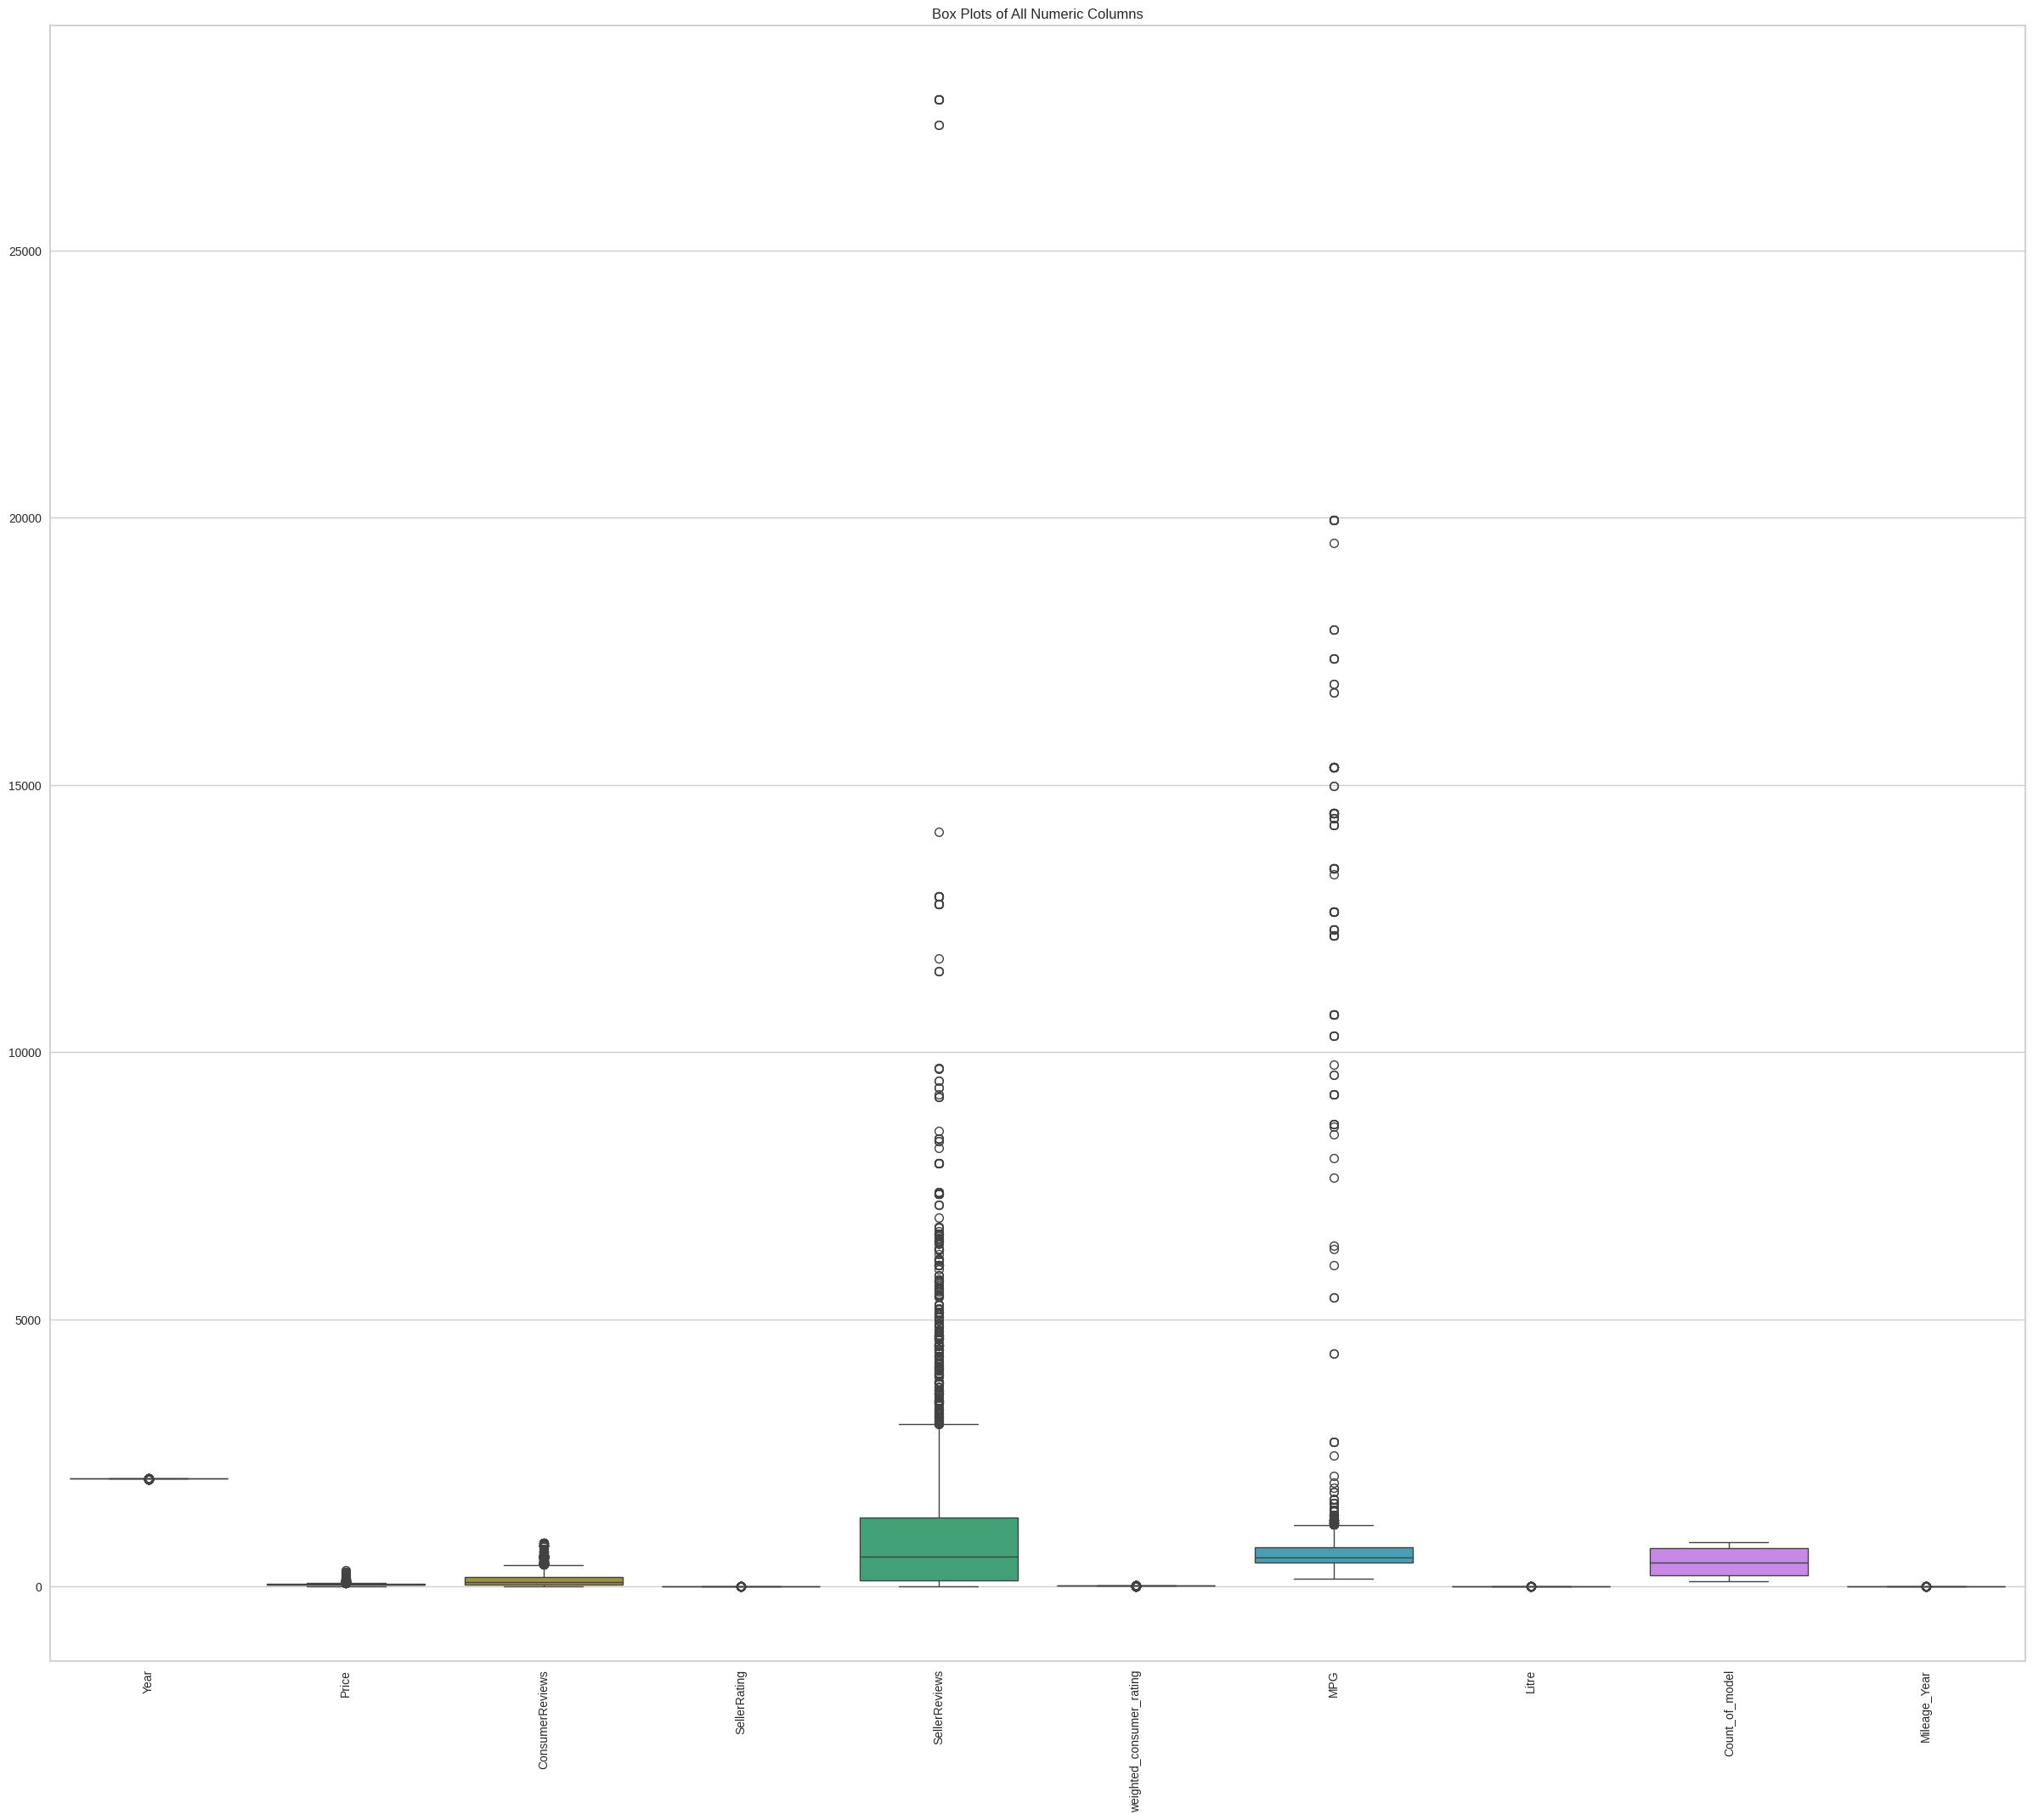

In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(30, 25))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=90)
plt.title('Box Plots of All Numeric Columns')
plt.show()


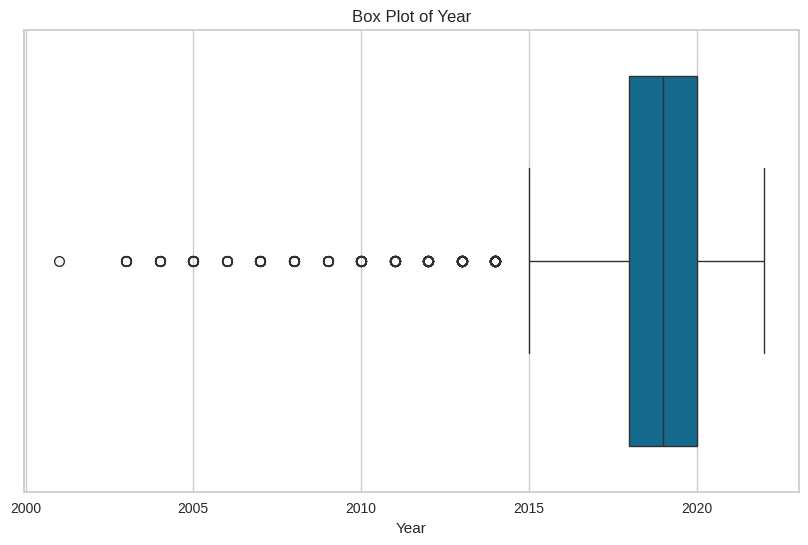

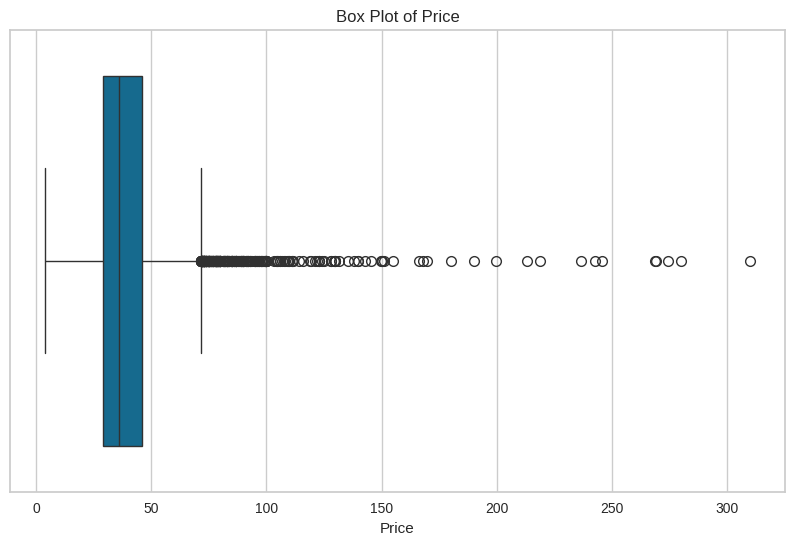

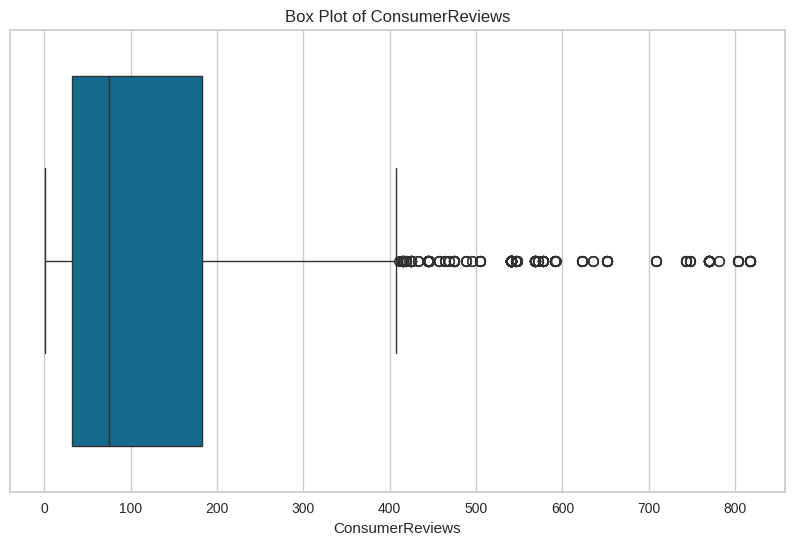

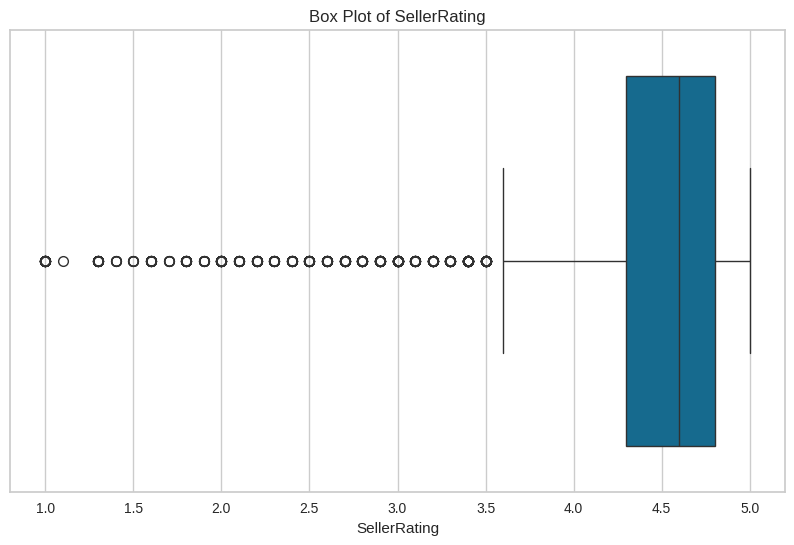

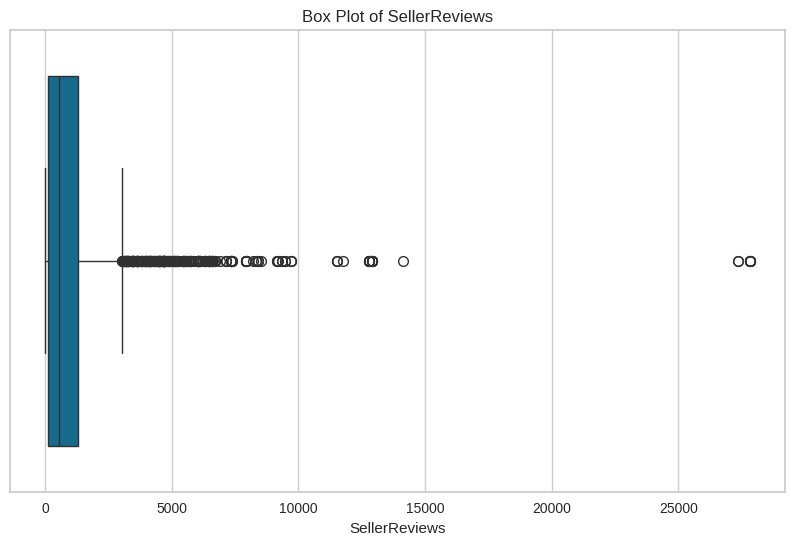

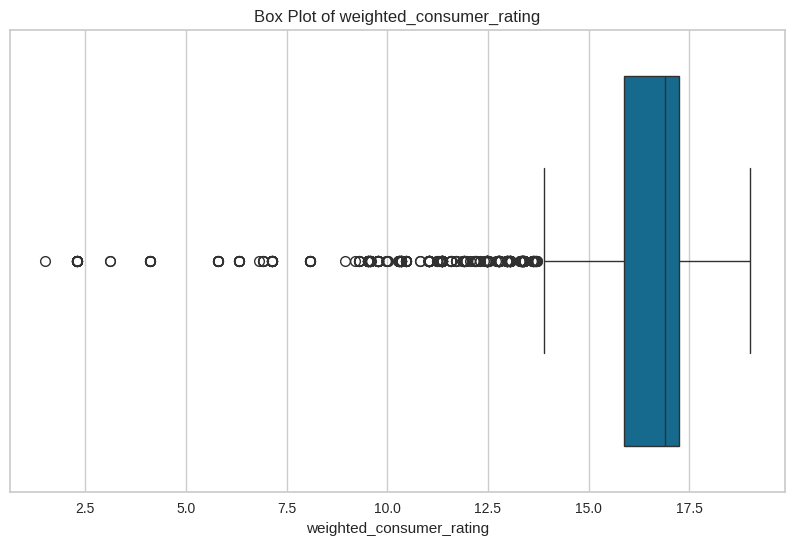

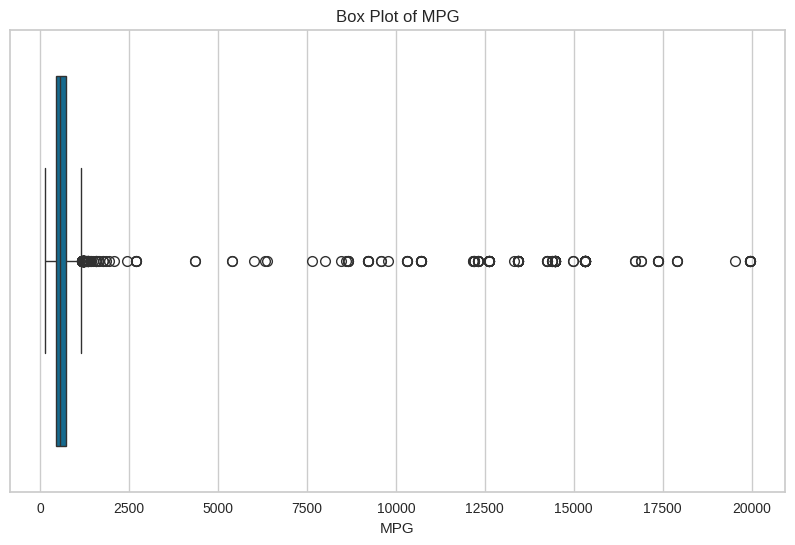

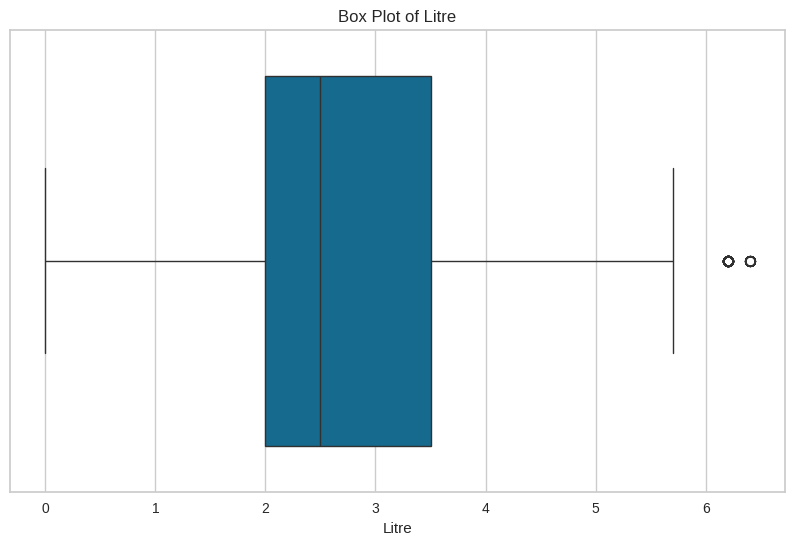

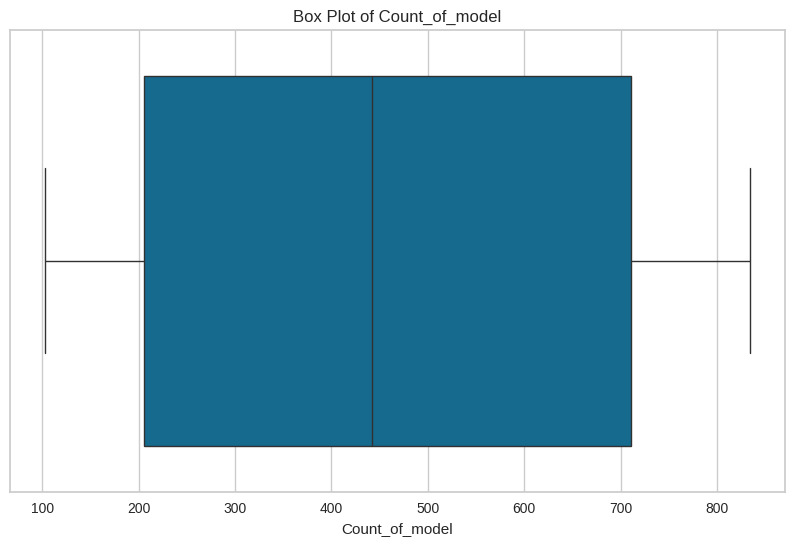

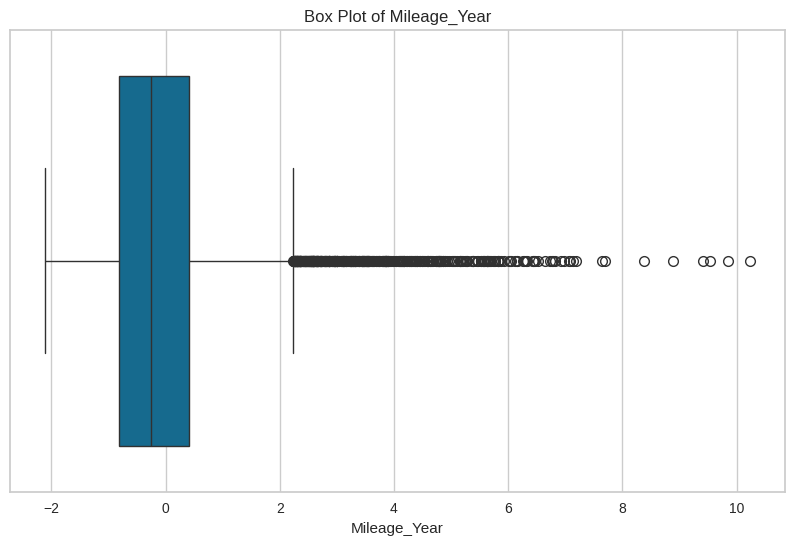

In [ ]:
#outlie durumöarını gözlemlediimizde Sellerreviews'de daha açık görüyoruz
numeric_cols = df.select_dtypes(include=['number']).columns

# Her bir sayısal sütun için box plot oluşturma
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()


In [ ]:
df[df["SellerReviews"]>15000]  # 8 tane değer var. burda drop işlemi yapabiliriz outlier değerler için

In [ ]:
value_counts = df['SellerReviews'].value_counts()

to_drop = value_counts[value_counts < 2].index

# to_drop listesindeki indekslere sahip satırları düşürür
df = df[~df['SellerReviews'].isin(to_drop)]

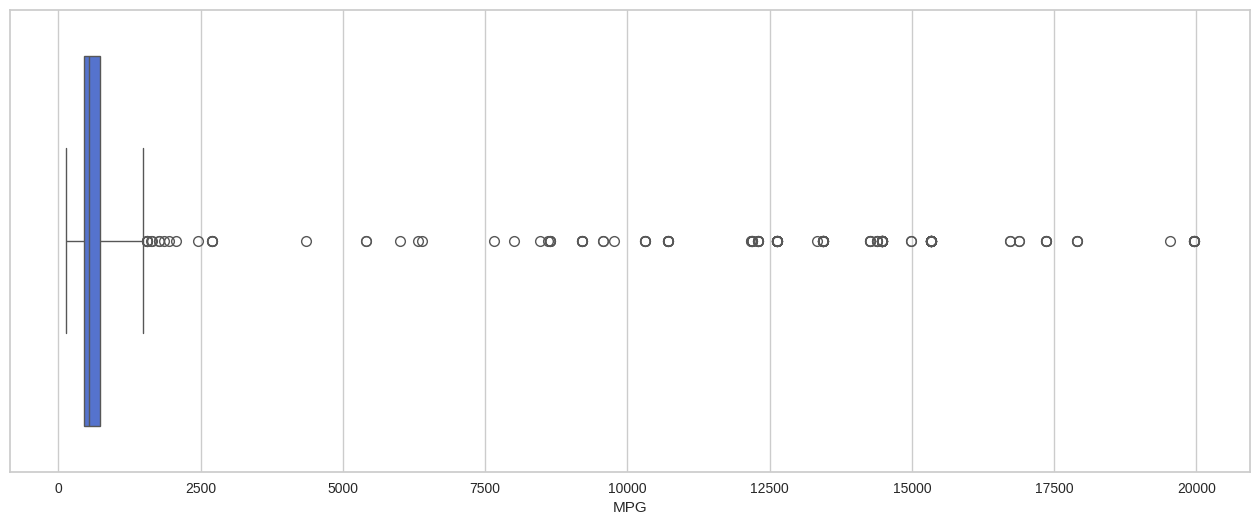

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(x="MPG", data=df, whis=3, color="royalblue")
plt.show()

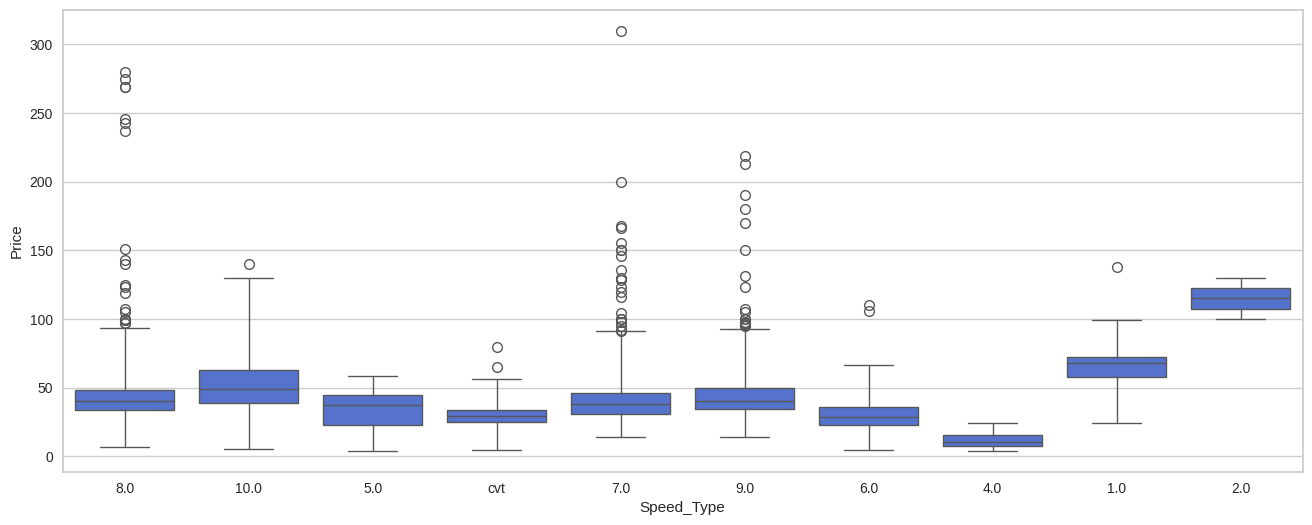

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(x="Speed_Type", y="Price", data=df, whis=3, color="royalblue")
plt.show()

In [ ]:
df.drop(["Model", "SellerName", "StreetName", "State", "ExteriorColor", "InteriorColor", "VIN", "Stock#"], axis=1, inplace=True)

In [ ]:
df = df.join(df["Drivetrain"].str.get_dummies().add_prefix("dt_"))
df = df.join(df["DealType"].str.get_dummies().add_prefix("deal_"))
df = df.join(df["FuelType"].str.get_dummies().add_prefix("dt_"))
df = df.join(df["Make"].str.get_dummies().add_prefix("mk_")) #make'i encode yapıcaz ya da drop
df = df.join(df["Cylindder_Arrangement"].str.get_dummies().add_prefix("ca_"))


In [ ]:
df.drop(["Year","DealType", "Drivetrain", "FuelType","Zipcode","Make","Cylindder_Arrangement"], axis=1, inplace=True)

In [ ]:
df.Speed_Type =  df.Speed_Type.astype(str)

In [ ]:

label_encoder = LabelEncoder()

columns_to_encode = ['Used/New', 'SellerType', "Transmission_Type", "Speed_Type"]

for col in columns_to_encode:
    df[col] = label_encoder.fit_transform(df[col])

df

,Year,Used/New,Price,ConsumerReviews,SellerType,SellerRating,SellerReviews,Transmission_Type,Speed_Type,weighted_consumer_rating,MPG,Litre,Count_of_model,Mileage_Year,dt_4WD,dt_AWD,dt_FWD,dt_RWD,deal_Fair,deal_Good,deal_Great,dt_Diesel,dt_E85 Flex Fuel,dt_Electric,dt_Flex Fuel Capability,dt_Flexible Fuel,dt_Gasoline,dt_Gasoline Fuel,dt_Gasoline/Mild Electric Hybrid,dt_Hybrid,mk_Acura,mk_Audi,mk_BMW,mk_Buick,mk_Cadillac,mk_Chevrolet,mk_Dodge,mk_Ford,mk_GMC,mk_Honda,mk_Hyundai,mk_INFINITI,mk_Jeep,mk_Kia,mk_Land,mk_Lexus,mk_Lincoln,mk_Mazda,mk_Mercedes-Benz,mk_Nissan,mk_Other,mk_Porsche,mk_RAM,mk_Subaru,mk_Tesla,mk_Toyota,mk_Volkswagen,mk_Volvo,ca_Electric,ca_H4,ca_H6,ca_I3,ca_I4,ca_I5,ca_I6,ca_V10,ca_V6,ca_V8
0,2019,1,39.998,45,0,3.3,3,0,7,15.856,513,3.5,711,-0.300901,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,2018,1,49.985,817,0,4.8,131,0,1,16.574,456,3.5,517,0.124094,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2017,1,41.860,495,0,4.6,249,0,7,16.544,315,5.7,135,0.172050,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2012,1,23.541,34,0,4.4,1071,0,4,17.188,391,4.0,711,4.132713,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5,2017,1,20.995,200,0,4.4,2695,1,9,16.500,952,1.8,616,-0.188894,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8266,2019,1,33.277,540,0,4.7,4705,1,9,17.232,891,1.5,616,-0.623891,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8269,2019,1,31.999,540,0,4.8,1917,1,9,17.232,891,1.5,616,0.127121,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8270,2019,1,27.374,205,0,4.4,443,1,9,17.202,891,2.0,254,-0.692560,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8271,2017,1,26.944,137,0,4.7,831,0,5,16.896,330,3.6,103,1.292663,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.Speed_Type.value_counts()

Speed_Type
7    2818
5    1463
9    1076
8     898
1     711
6     522
0     150
4     149
3      27
2       2
Name: count, dtype: int64

In [ ]:
df.isnull().any().any()


False

In [ ]:
corr_by_price = df.corr()["Price"].sort_values()[:-1]
corr_by_price

Mileage_Year        -0.413001
ca_I4               -0.349844
dt_FWD              -0.325169
ConsumerReviews     -0.324062
Transmission_Type   -0.213440
                       ...   
ca_Electric          0.197205
mk_Tesla             0.203597
ca_H6                0.219318
mk_Porsche           0.220880
ca_V8                0.326952
Name: Price, Length: 66, dtype: float64

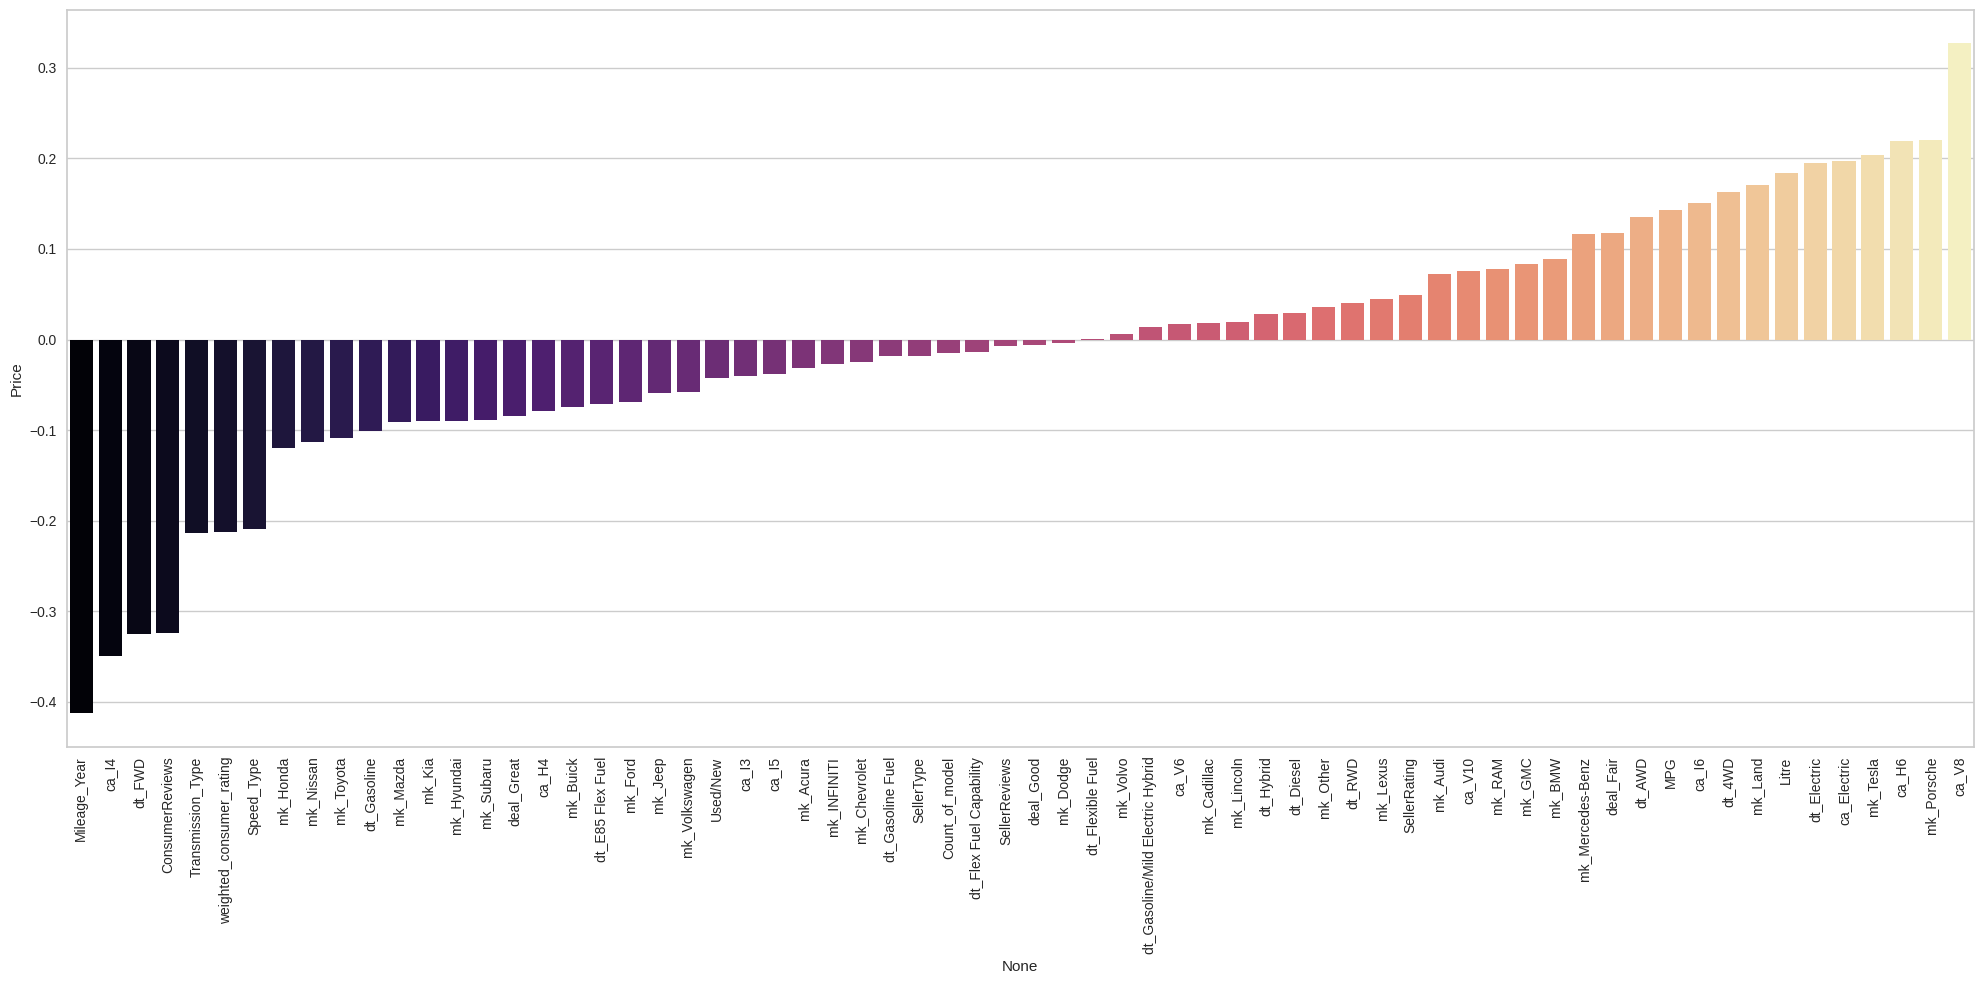

In [ ]:
plt.figure(figsize = (20,10))
sns.barplot(x = corr_by_price.index, y = corr_by_price, palette="magma")
plt.xticks(rotation=90)
plt.tight_layout();


# Lazy Predict

In [ ]:
pd.set_option('display.max_columns', None)

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

# Train - Test

### encode işelmelrini X ğzerinden alıp yapabilrisin daha düzelidir

In [ ]:
X= df.drop(columns="Price")
y= df.Price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
X_train.shape

(6252, 66)

In [ ]:
X_test.shape

(1570, 81)

# XGBoost

In [ ]:
from xgboost import XGBRegressor


In [ ]:
operations = [("XGB_model", XGBRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)


pipe_model.fit(X_train, y_train)


Pipeline(steps=[('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=101, ...))])

In [ ]:
train_val(pipe_model, X_train, y_train, X_test, y_test)


,train,test
R2,0.987817,0.907492
mae,1.504697,3.108936
mse,4.072580,30.637413
rmse,2.018064,5.535107


## CV yaptıktan sonra

In [ ]:
model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring=['r2',
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10,
                       return_train_score=True)
pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                               0.897873
train_r2                              0.988571
test_neg_mean_absolute_error         -3.144057
train_neg_mean_absolute_error        -1.455685
test_neg_mean_squared_error         -34.863058
train_neg_mean_squared_error         -3.815269
test_neg_root_mean_squared_error     -5.730726
train_neg_root_mean_squared_error    -1.952926
dtype: float64

## XGBoost model tunning

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
#default değerlere bak, gereksiz parametre koymak sıkıntı yaratabilir
param_grid = {
    "XGB_model__n_estimators": [100],
    "XGB_model__max_depth": [6],
    "XGB_model__learning_rate": [0.3],
    "XGB_model__subsample": [1],
    "XGB_model__colsample_bytree": [1]
}

In [ ]:
operations = [("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',# farklı error metricleri bakabilrisin
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True).fit(X_train, y_train)

In [ ]:
grid_model.best_params_


{'XGB_model__colsample_bytree': 1,
 'XGB_model__learning_rate': 0.3,
 'XGB_model__max_depth': 6,
 'XGB_model__n_estimators': 100,
 'XGB_model__subsample': 1}

In [ ]:
grid_model.best_score_


-5.7307256634752655

In [ ]:
y_pred = grid_model.predict(X_test)
XGB_R2 = r2_score(y_test, y_pred)
XGB_mae = mean_absolute_error(y_test, y_pred)
XGB_mse = mean_squared_error(y_test, y_pred)
XGB_rmse = mean_squared_error(y_test, y_pred, squared=False)
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.987817,0.907492
mae,1.504697,3.108936
mse,4.072580,30.637413
rmse,2.018064,5.535107


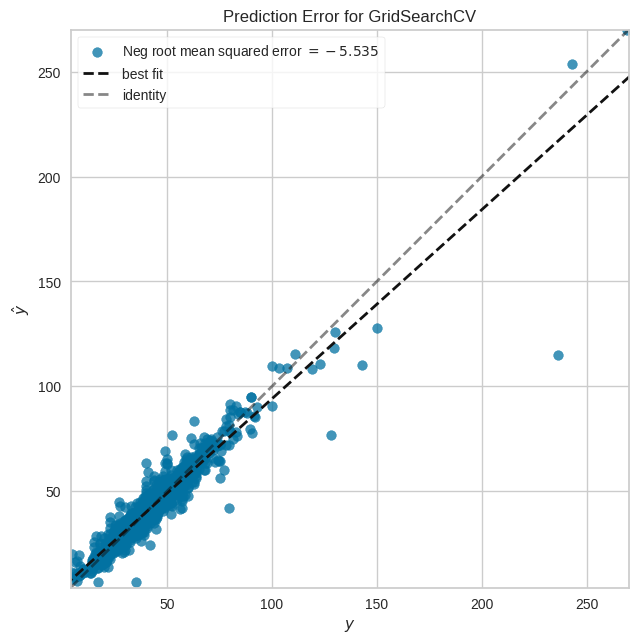

In [ ]:
visualizer = RadViz(size=(720, 3000))
visualizer = PredictionError(grid_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();
#Ortadaki çizgi mükemmel olandır. ama. bu iki çizgiyi birbirne yakınlaştırmaktır.
#burdan outlier tespiti de yaparız ve görürüz hataya sebep var mı diye

In [ ]:
df[df["Price"]>100.000]

,Year,Used/New,Price,ConsumerReviews,SellerType,SellerRating,SellerReviews,ComfortRating,PerformanceRating,Mileage,Transmission_Type,Speed_Type,MPG,desing_rate,Litre,Count_of_model,year_of_age,weighted_consumer_rating,dt_4WD,dt_AWD,dt_FWD,dt_RWD,deal_Fair,deal_Good,deal_Great,dt_Diesel,dt_E85 Flex Fuel,dt_Electric,dt_Flex Fuel Capability,dt_Flexible Fuel,dt_Gasoline,dt_Gasoline Fuel,dt_Gasoline/Mild Electric Hybrid,dt_Hybrid,mk_Acura,mk_Audi,mk_BMW,mk_Buick,mk_Cadillac,mk_Chevrolet,mk_Dodge,mk_Ford,mk_GMC,mk_Honda,mk_Hyundai,mk_INFINITI,mk_Jeep,mk_Kia,mk_Land,mk_Lexus,mk_Lincoln,mk_Mazda,mk_Mercedes-Benz,mk_Nissan,mk_Other,mk_Porsche,mk_RAM,mk_Subaru,mk_Tesla,mk_Toyota,mk_Volkswagen,mk_Volvo,ca_Electric,ca_H4,ca_H6,ca_I3,ca_I4,ca_I5,ca_I6,ca_V10,ca_V6,ca_V8
63,2019,0,106.999,2,0,4.7,738,5.0,5.0,15113,0,8,345,25.00,4.0,736,5,17.250,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
121,2021,1,107.998,19,0,3.7,6,3.5,2.6,28000,0,1,266,15.58,6.2,250,3,4.104,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
451,2019,1,140.000,16,0,4.7,114,4.7,4.5,37601,0,1,266,20.70,0.0,153,5,13.362,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
719,2017,0,127.999,3,0,4.8,1252,4.3,5.0,30230,0,6,168,21.50,5.5,736,7,17.890,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
734,2021,0,122.999,1,0,4.7,1113,5.0,5.0,7359,0,8,336,25.00,4.0,736,3,15.470,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7197,2017,0,167.992,45,0,4.9,494,4.6,5.0,17520,0,6,456,23.52,3.8,112,7,16.840,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7487,2019,1,242.888,6,0,4.7,148,5.0,5.0,13959,0,7,204,25.00,4.0,164,5,16.590,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7633,2021,0,107.489,3,0,4.6,431,4.7,5.0,22000,0,7,234,25.00,4.4,834,3,17.920,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7914,2016,1,199.500,7,0,3.5,63,4.4,5.0,37674,0,6,294,23.03,5.2,164,8,16.896,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


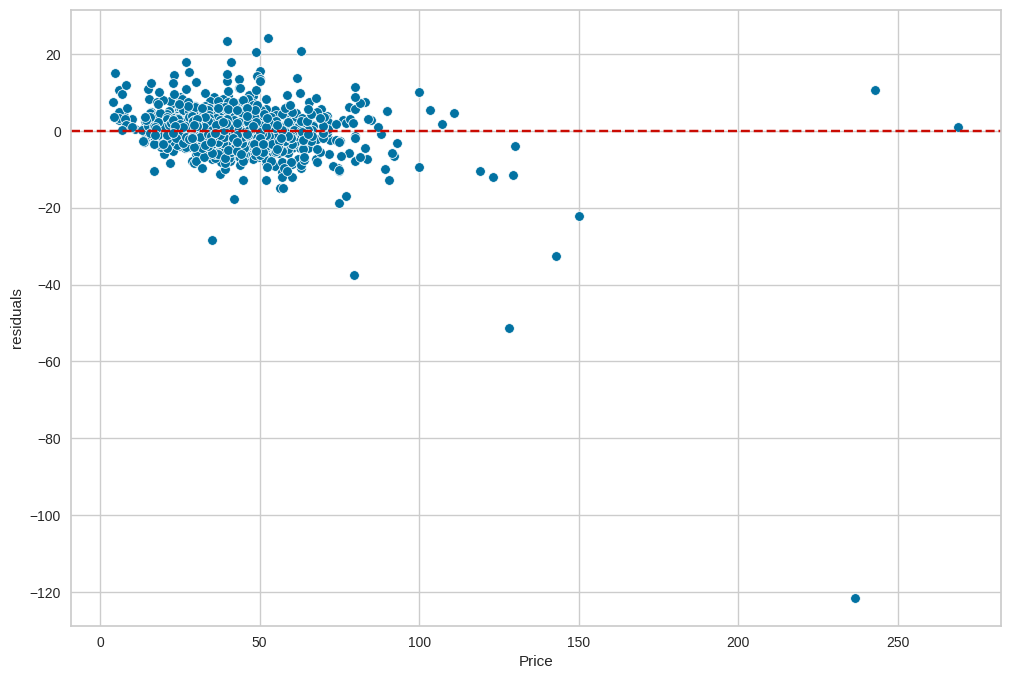

In [ ]:
plt.figure(figsize=(12,8))
residuals = y_test-y_pred

sns.scatterplot(x = y_test, y = -residuals) #-residuals
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()



In [ ]:
df1 = df[~(df.Price>80.000)]
df1.head()


,Used/New,Price,ConsumerReviews,SellerType,SellerRating,SellerReviews,Transmission_Type,Speed_Type,weighted_consumer_rating,MPG,Litre,Count_of_model,Mileage_Year,dt_4WD,dt_AWD,dt_FWD,dt_RWD,deal_Fair,deal_Good,deal_Great,dt_Diesel,dt_E85 Flex Fuel,dt_Electric,dt_Flex Fuel Capability,dt_Flexible Fuel,dt_Gasoline,dt_Gasoline Fuel,dt_Gasoline/Mild Electric Hybrid,dt_Hybrid,mk_Acura,mk_Audi,mk_BMW,mk_Buick,mk_Cadillac,mk_Chevrolet,mk_Dodge,mk_Ford,mk_GMC,mk_Honda,mk_Hyundai,mk_INFINITI,mk_Jeep,mk_Kia,mk_Land,mk_Lexus,mk_Lincoln,mk_Mazda,mk_Mercedes-Benz,mk_Nissan,mk_Other,mk_Porsche,mk_RAM,mk_Subaru,mk_Tesla,mk_Toyota,mk_Volkswagen,mk_Volvo,ca_Electric,ca_H4,ca_H6,ca_I3,ca_I4,ca_I5,ca_I6,ca_V10,ca_V6,ca_V8
0,1,39.998,45,0,3.3,3,0,7,15.856,513,3.5,711,-0.300901,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1,49.985,817,0,4.8,131,0,1,16.574,456,3.5,517,0.124094,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,41.860,495,0,4.6,249,0,7,16.544,315,5.7,135,0.172050,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,23.541,34,0,4.4,1071,0,4,17.188,391,4.0,711,4.132713,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5,1,20.995,200,0,4.4,2695,1,9,16.500,952,1.8,616,-0.188894,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
X = df1.drop(columns = "Price")
y = df1.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
operations = [("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True).fit(X_train, y_train)

In [ ]:
y_pred = grid_model.predict(X_test)
XGB_R2 = r2_score(y_test, y_pred)
XGB_mae = mean_absolute_error(y_test, y_pred)
XGB_mse = mean_squared_error(y_test, y_pred)
XGB_rmse = mean_squared_error(y_test, y_pred, squared=False)
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.980405,0.912963
mae,1.422870,2.770106
mse,3.609313,14.787374
rmse,1.899819,3.845436


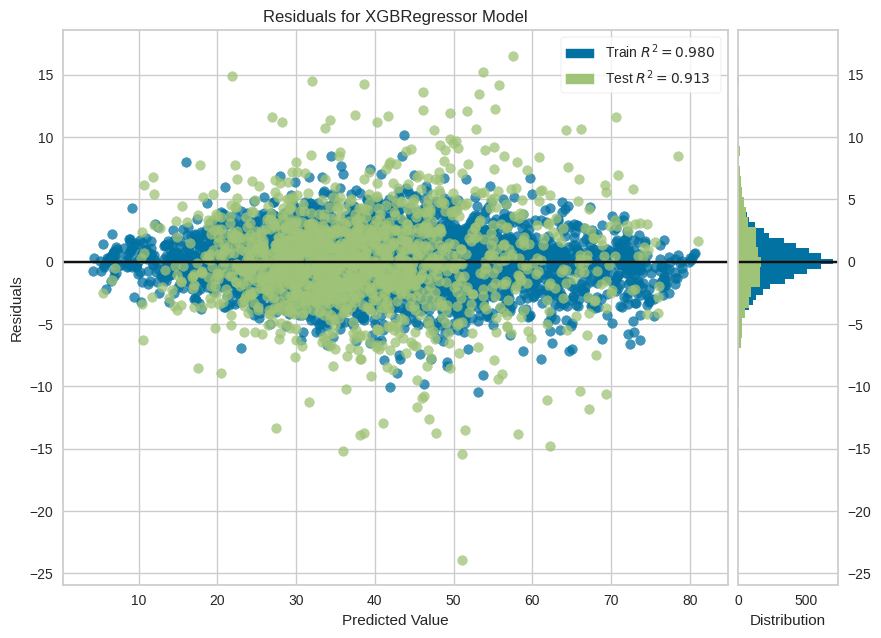

In [ ]:

visualizer = RadViz(size=(1000, 720))
visualizer = ResidualsPlot(pipe_model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

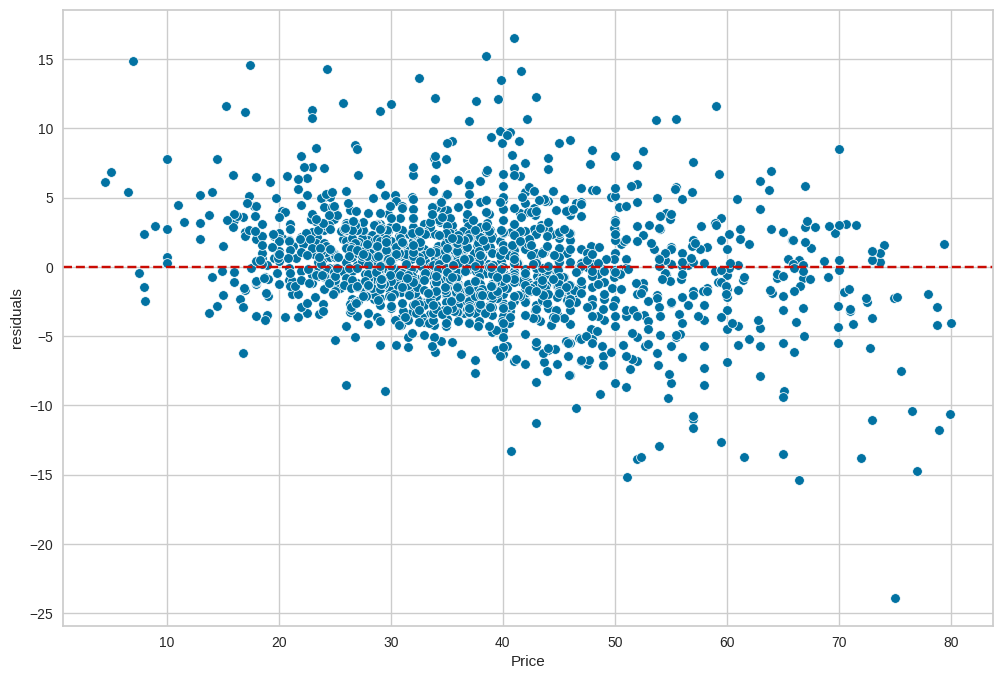

In [ ]:
plt.figure(figsize=(12,8))
residuals = y_test-y_pred

sns.scatterplot(x = y_test, y = -residuals) #-residuals
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()



# Regularization

In [ ]:
param_grid_reg = {
    "XGB_model__n_estimators": [100],
    "XGB_model__max_depth": [6],
    "XGB_model__learning_rate": [0.3],
    "XGB_model__subsample": [1],
    "XGB_model__colsample_bytree": [1],
    'XGB_model__reg_alpha': [0.5],  # L1 regülarizasyon parametresi
    'XGB_model__reg_lambda': [1.5]  # L2 regülarizasyon parametresi
}

In [ ]:
operations = [("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model, param_grid=param_grid_reg, cv=10, scoring='neg_mean_squared_error', verbose=1)
grid_model.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('XGB_model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constra...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=101, ...))]),
             param_grid={'XGB_model__colsample_bytree': [1],
                         'XGB_model__learning_rate': [0.3],
                         'XGB_model__max_depth': [6],
                         'XGB_model__n_estimators': [100],
                         'XGB_model__reg_alpha': [0.5],
                         'XGB_model__reg_lambda': [1.5],
                         'XGB_model__subsample': [1]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
y_pred = grid_model.predict(X_test)
XGB_R2 = r2_score(y_test, y_pred)
XGB_mae = mean_absolute_error(y_test, y_pred)
XGB_mse = mean_squared_error(y_test, y_pred)
XGB_rmse = mean_squared_error(y_test, y_pred, squared=False)
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.979725,0.914114
mae,1.438927,2.779888
mse,3.734539,14.591806
rmse,1.932495,3.819922


In [ ]:
print("En iyi parametreler:", grid_model.best_params_)
print("En iyi MSE değeri:", -grid_model.best_score_)


En iyi parametreler: {'XGB_model__colsample_bytree': 1, 'XGB_model__learning_rate': 0.3, 'XGB_model__max_depth': 6, 'XGB_model__n_estimators': 100, 'XGB_model__reg_alpha': 0.5, 'XGB_model__reg_lambda': 1.5, 'XGB_model__subsample': 1}
En iyi MSE değeri: 15.620469306785164


# feature Importance


In [ ]:
operations = [
              ("XGB_model",
               XGBRegressor(n_estimators=100,
                            learning_rate=0.06,
                            max_depth=3,
                            random_state=101,
                            subsample=0.5))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.06,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=101, ...))])

In [ ]:
imp_feats = pd.DataFrame(data=pipe_model["XGB_model"].feature_importances_, columns=['XGB_Importance'], index=X_train.columns)
xgb_imp_feats = imp_feats.sort_values('XGB_Importance', ascending=False)
xgb_imp_feats

,XGB_Importance
dt_FWD,0.170536
ConsumerReviews,0.135863
ca_I4,0.112598
Mileage_Year,0.055712
MPG,0.048287
...,...
mk_Cadillac,0.000000
mk_Buick,0.000000
mk_BMW,0.000000
dt_Gasoline/Mild Electric Hybrid,0.000000


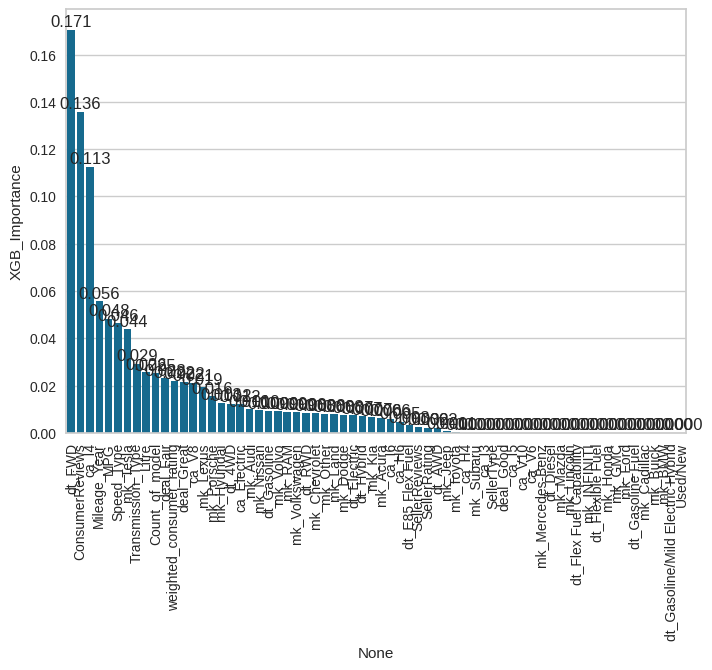

In [ ]:

ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y='XGB_Importance')
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.xticks(rotation=90);

# LightGBM

In [ ]:
from lightgbm import LGBMRegressor


In [ ]:
operations = [("LGBM_model", LGBMRegressor(random_state=101, objective='regression'))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 6112, number of used features: 57
[LightGBM] [Info] Start training from score 38.009370


Pipeline(steps=[('LGBM_model',
                 LGBMRegressor(objective='regression', random_state=101))])

In [ ]:
train_val(pipe_model, X_train, y_train, X_test, y_test)


,train,test
R2,0.950076,0.912924
mae,2.238194,2.791501
mse,9.195665,14.794039
rmse,3.032436,3.846302


In [ ]:
operations = [("LGBM_model",
               LGBMRegressor(random_state=101, objective='regression'))]

model = Pipeline(steps=operations)
scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=[
                            'r2', 'neg_mean_absolute_error',
                            'neg_mean_squared_error',
                            'neg_root_mean_squared_error'
                        ],
                        cv=10,
                        return_train_score=True)

pd.DataFrame(scores).mean()[2:]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 57
[LightGBM] [Info] Start training from score 38.147237
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 57
[LightGBM] [Info] Start training from score 38.001767
[LightGBM] [Warning] Found w

test_r2                               0.908339
train_r2                              0.951221
test_neg_mean_absolute_error         -2.860147
train_neg_mean_absolute_error        -2.214595
test_neg_mean_squared_error         -16.749784
train_neg_mean_squared_error         -8.984068
test_neg_root_mean_squared_error     -4.082280
train_neg_root_mean_squared_error    -2.997288
dtype: float64

In [ ]:
param_grid = {
    'LGBM_model__learning_rate': [0.01, 0.05, 0.1],
    'LGBM_model__n_estimators': [100, 200, 500],
    'LGBM_model__max_depth': [3, 5],
    "LGBM_model__num_leaves": [8, 32, 256],  # 2^max_depth'e uygun değerler ikinin maxdepth kuvvetini al demek.
    'LGBM_model__subsample': [0.8, 1.0],
    'LGBM_model__colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
operations = [("LGBM_model", LGBMRegressor(random_state=101, objective='regression', verbose=-1))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True).fit(X_train, y_train)

In [ ]:
grid_model.best_params_


{'LGBM_model__colsample_bytree': 0.8,
 'LGBM_model__learning_rate': 0.1,
 'LGBM_model__max_depth': 5,
 'LGBM_model__n_estimators': 500,
 'LGBM_model__num_leaves': 32,
 'LGBM_model__subsample': 0.8}

In [ ]:
grid_model.best_score_


-3.831668050798387

In [ ]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.968406,0.915584
mae,1.782575,2.725756
mse,5.819528,14.342058
rmse,2.412370,3.787091


In [ ]:
y_pred = grid_model.predict(X_test)
LGBM_R2 = r2_score(y_test, y_pred)
LGBM_mae = mean_absolute_error(y_test, y_pred)
LGBM_mse = mean_squared_error(y_test, y_pred)
LGBM_rmse = mean_squared_error(y_test, y_pred, squared=False)
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.968406,0.915584
mae,1.782575,2.725756
mse,5.819528,14.342058
rmse,2.412370,3.787091


# Feature Importance

In [ ]:
operations = [
              ("LGBM_model",
               LGBMRegressor(random_state=101,
                             objective='regression',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             subsample=0.8,
                             n_estimators=200,
                             verbose=-1))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('LGBM_model',
                 LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05,
                               max_depth=3, n_estimators=200,
                               objective='regression', random_state=101,
                               subsample=0.8, verbose=-1))])

In [ ]:
pipe_model["LGBM_model"].feature_importances_


array([  8, 106,   0,  10,  21,   2,  91,  74, 174,  94,  66, 274,   7,
         7,  19,   3,  28,   0,  32,   0,   7,   1,   0,   0,   4,   0,
         0,   8,   3,  20,   0,   1,   0,   2,  17,   0,   0,   4,   4,
         1,   6,   7,   5,  15,   0,   0,  12,  10,   5,  28,  11,   0,
        24,   0,  12,  10,   2,   0,   0,   0,  24,   0,   9,   0,   3,
        12], dtype=int32)

In [ ]:
imp_feats = pd.DataFrame(data=pipe_model["LGBM_model"].feature_importances_, columns=['LGBM_Importance'], index=X_train.columns)
lgbm_imp_feats = imp_feats.sort_values('LGBM_Importance', ascending=False)
lgbm_imp_feats

,LGBM_Importance
Mileage_Year,274
MPG,174
ConsumerReviews,106
Litre,94
Speed_Type,91
...,...
deal_Good,0
dt_Diesel,0
mk_GMC,0
dt_Flex Fuel Capability,0


In [ ]:
pd.concat([ xgb_imp_feats, lgbm_imp_feats], axis=1).head(10)


,XGB_Importance,LGBM_Importance
dt_FWD,0.170536,19
ConsumerReviews,0.135863,106
ca_I4,0.112598,24
Mileage_Year,0.055712,274
MPG,0.048287,174
Speed_Type,0.046452,91
mk_Tesla,0.043928,24
Transmission_Type,0.029282,2
Litre,0.025587,94
Count_of_model,0.025188,66


# Final Model

In [ ]:
X2 = df1[["ConsumerReviews", "ca_I4", "dt_FWD", "Mileage_Year","MPG","Speed_Type","mk_Tesla" ]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.1, random_state=101)


In [ ]:
model = XGBRegressor(random_state=101, objective="reg:squarederror")


In [ ]:
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=101, ...)

In [ ]:
train_val(model, X_train, y_train, X_test, y_test)


,train,test
R2,0.960169,0.876821
mae,1.996652,3.312073
mse,7.231503,22.025387
rmse,2.689145,4.693121


In [ ]:
model = XGBRegressor(random_state=101, objective="reg:squarederror")
scores = cross_validate(model, X_train, y_train, scoring=['r2',
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10)

In [ ]:
param_grid_reg = {
    "XGB_model__n_estimators": [100],
    "XGB_model__max_depth": [6],
    "XGB_model__learning_rate": [0.3],
    "XGB_model__subsample": [1],
    "XGB_model__colsample_bytree": [1],
}

In [ ]:
model = XGBRegressor(random_state=101, objective="reg:squarederror")
grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1)

In [ ]:
grid_model.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=101, ...),
             n_jobs=-1,
             param_grid={'LGBM_model__colsample_bytree': [0.8, 0.9, 1.0],
                         'LGBM_model__learning_rate': [0.01, 0.05, 0.1],
                         'LGBM_model__max_depth': [3, 5],
                         'LGBM_model__n_estimators': [100, 200, 500],
                         'LGBM_model__num_leaves': [8, 32, 256],
                         'LGBM_model__subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error')

In [ ]:
train_val(grid_model, X_train, y_train, X_test, y_test)


,train,test
R2,0.960169,0.876821
mae,1.996652,3.312073
mse,7.231503,22.025387
rmse,2.689145,4.693121
